In [55]:
import pandas as pd
import numpy as np
from prophet import Prophet
import datetime
import matplotlib.pyplot as plt

In [32]:

#models for prophet predict
def prophetmodel(data: pd.DataFrame) -> list:
    """
    get prediction by using fbprophet
    :param data:  Dataframe - data with two columns date and y
    :return:      Dateframe - predict result
    """
    #the format cannot be chagne
    subset = pd.DataFrame({
        'ds': data.date,
        'y': data.iloc[:,1],
    })
    
    #define model parameters
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False, #since we are using daily data
        weekly_seasonality=True,
        yearly_seasonality=False,
        growth='linear',
    )
    
    m.add_country_holidays(country_name = "US") #added extra variables, like holiday
    
    m.fit(subset) #fit the model
    
    #predict for the next 28 days, frequency is daily
    future = m.make_future_dataframe(periods=28, freq='D')

    forecast = m.predict(future)
    
    #plot the forecast
    fig1 = m.plot(forecast)
    
    return forecast

In [75]:
data = pd.read_csv('/Users/yingding/Desktop/Forcasting M2/Project and data-20220107/Projectdata.csv')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')  #convert date into datetime
test = data.tail(28)     #train test split
train = data.iloc[:-28,:]

In [77]:
print(train.shape)
print(data.shape)

(1941, 19)
(1969, 19)


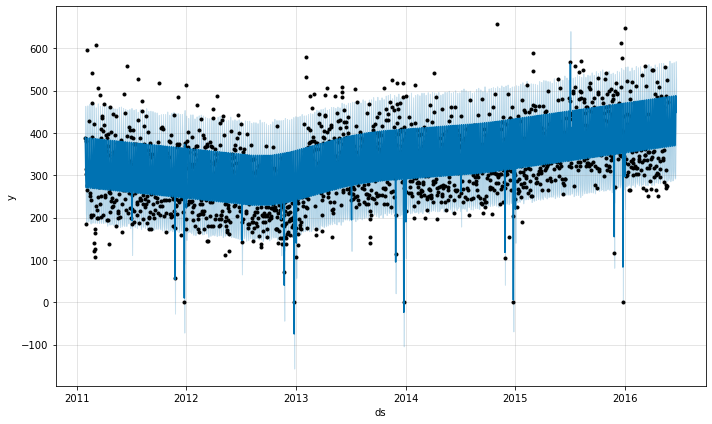

In [78]:
#try model with one variables
predict_data = train.iloc[:, [0,1]]
result = prophetmodel(predict_data)

In [79]:
len(train.columns)

19

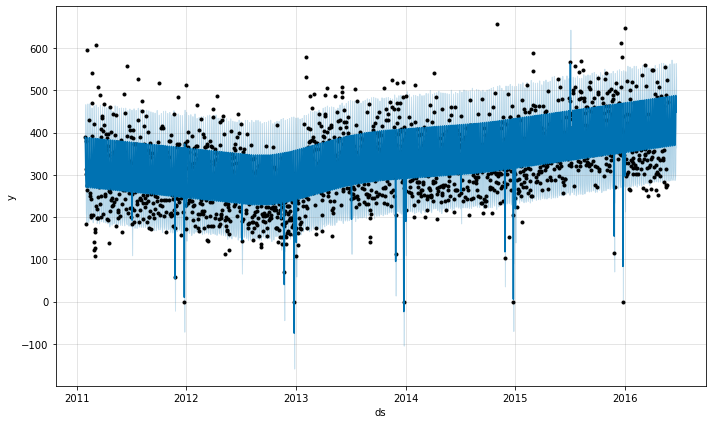

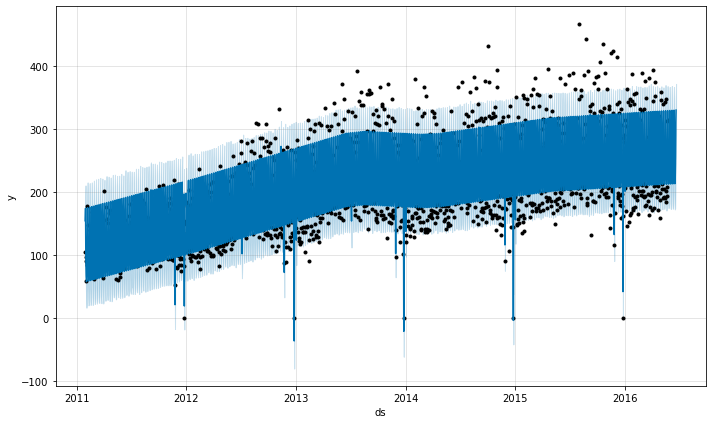

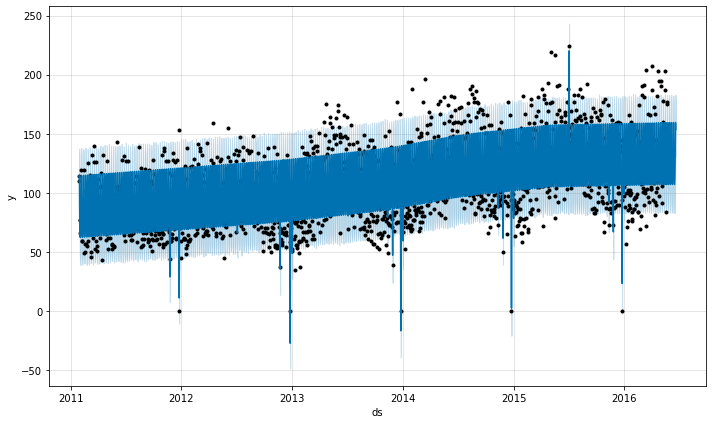

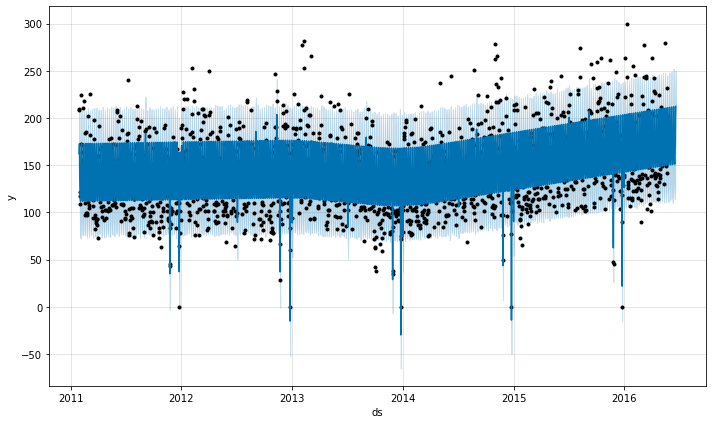

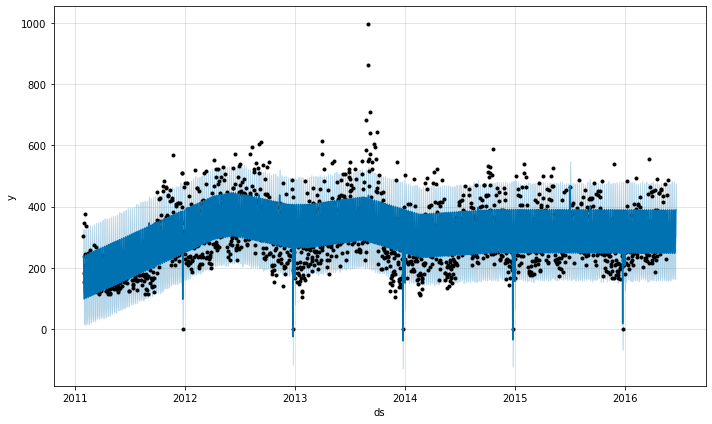

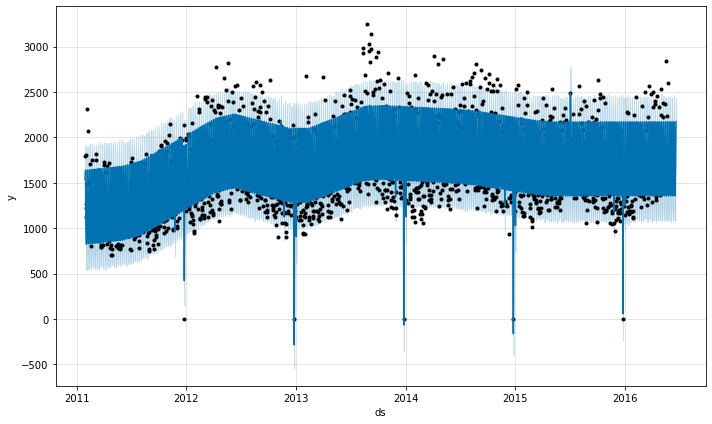

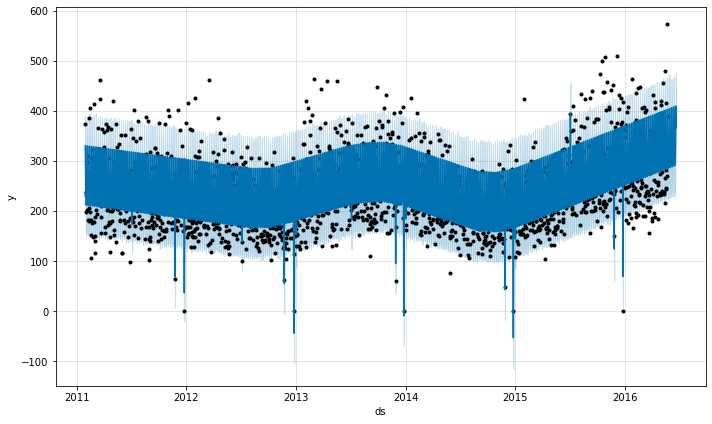

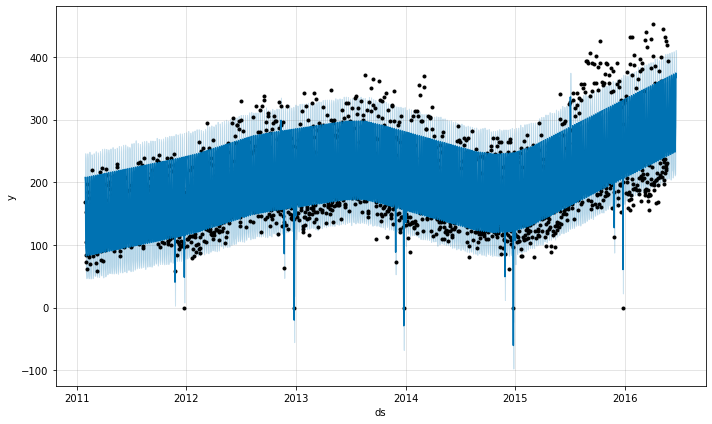

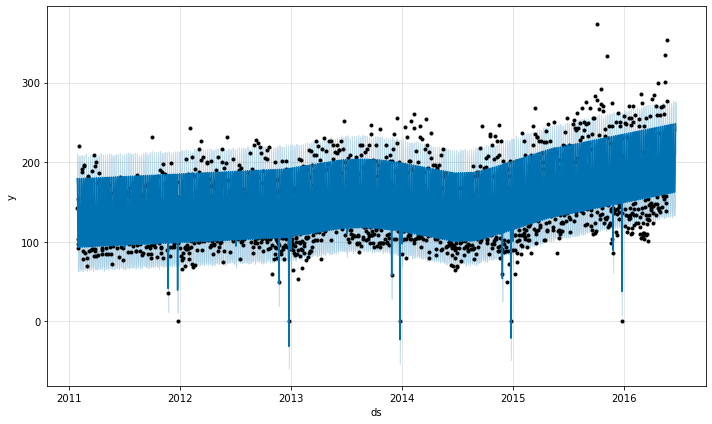

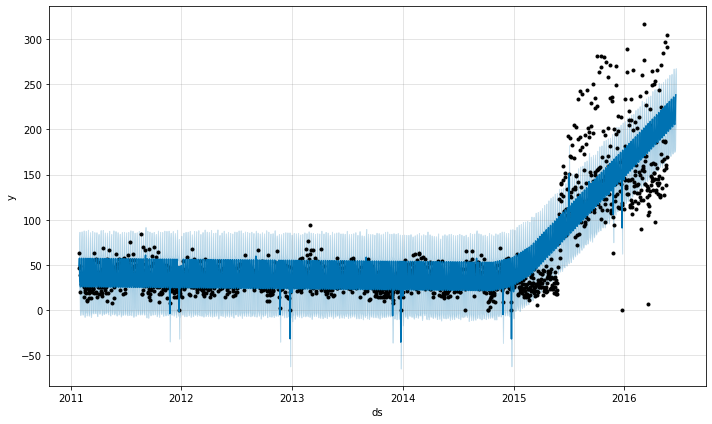

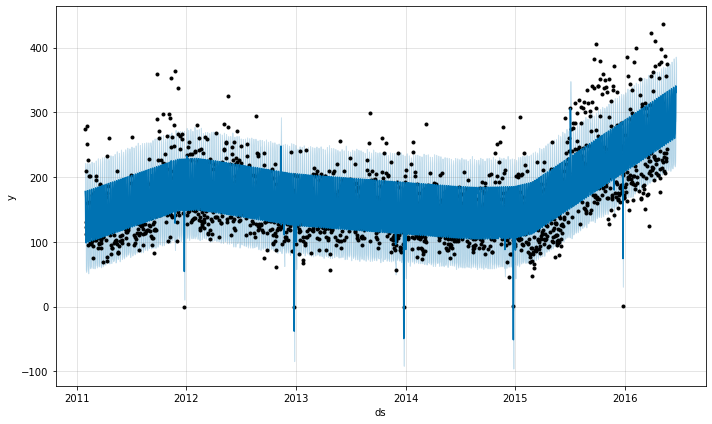

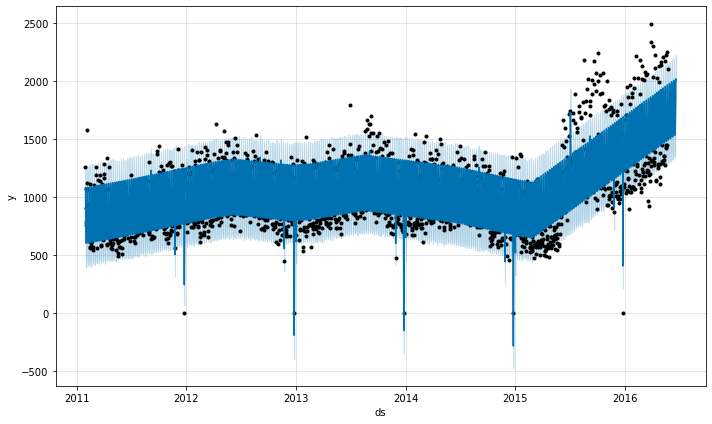

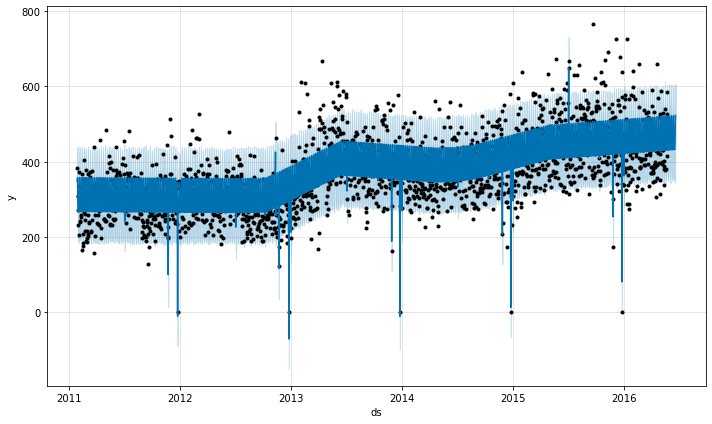

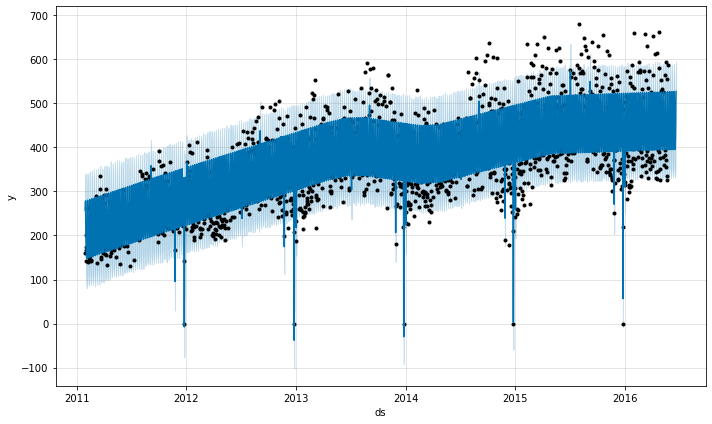

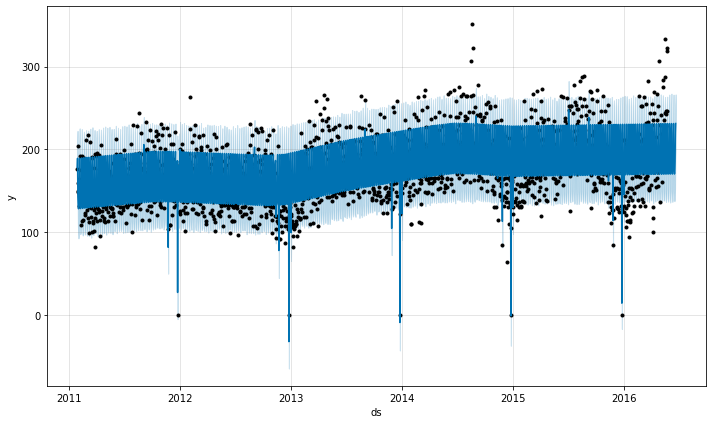

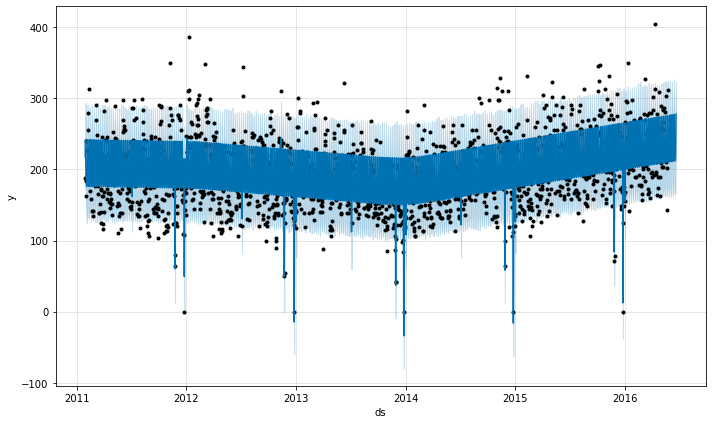

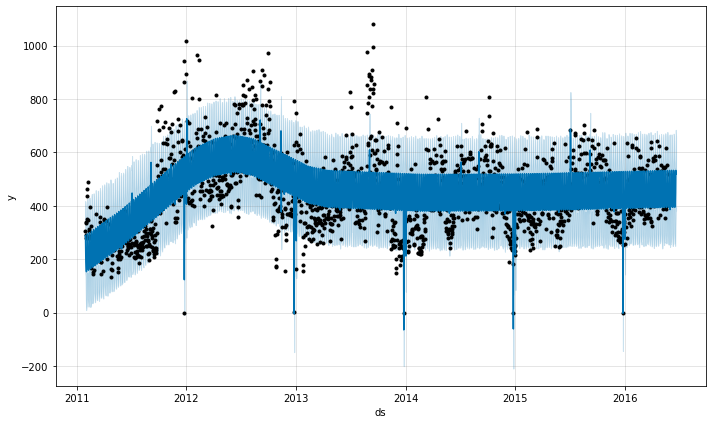

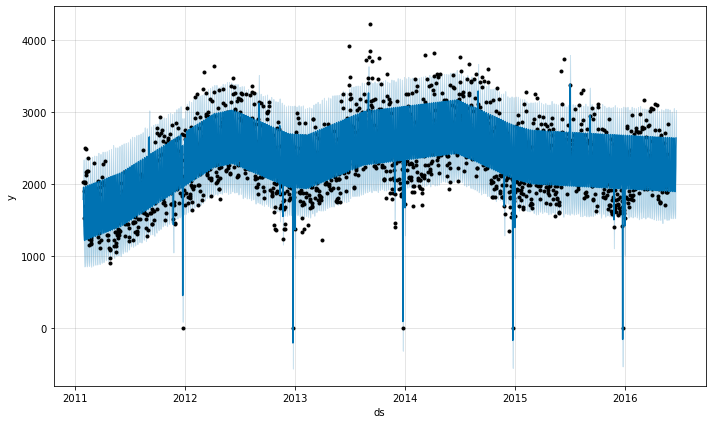

In [80]:
#loop to run forecast for every variable and plot the forecast

summary = []
for i in range(len(train.columns)-1):
    #print(i) 
    predict_data = train.iloc[:, [0,i+1]]
    result = prophetmodel(predict_data)
    summary.append(result)

In [104]:
print(summary[1])

             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0    2011-01-29   98.931887  113.623475  192.685771    98.931887    98.931887   
1    2011-01-30   99.060848  133.085225  210.328360    99.060848    99.060848   
2    2011-01-31   99.189809   54.890329  133.288883    99.189809    99.189809   
3    2011-02-01   99.318770   26.821542  107.226680    99.318770    99.318770   
4    2011-02-02   99.447731   16.334424   94.690551    99.447731    99.447731   
...         ...         ...         ...         ...          ...          ...   
1964 2016-06-15  254.753866  172.209926  251.617942   254.739700   254.781028   
1965 2016-06-16  254.783474  174.342675  252.763869   254.763676   254.814853   
1966 2016-06-17  254.813083  204.421434  283.560284   254.788232   254.849283   
1967 2016-06-18  254.842692  270.897228  348.688386   254.812992   254.889252   
1968 2016-06-19  254.872300  290.748347  371.475074   254.835618   254.926852   

      Christmas Day  Christ

In [115]:
#loop to add predict values : yhat for every variable 

y_hat = []
for i in range(len(summary)):
   y_hat.append(summary[i].yhat)

#convert list to dataframe and add date and columns
y_hat_total = pd.DataFrame(y_hat)
y_hat_total = y_hat_total.transpose()
date =summary[0].ds
y_hat_total.insert(0, column='date', value=date)
y_hat_total.columns = data.columns

#export to csv file to read in r
y_hat_total.to_csv('forecast_summary.csv', index=False)

print(y_hat_total)

           date  Hobbies_CA_1  Household_1_CA_1  Household_2_CA_1  \
0    2011-01-29    388.882201        154.307213        114.452481   
1    2011-01-30    349.283805        174.050890        108.677293   
2    2011-01-31    290.320449         93.389668         69.636538   
3    2011-02-01    270.864372         66.983196         63.026832   
4    2011-02-02    270.714761         57.760811         62.121703   
...         ...           ...               ...               ...   
1964 2016-06-15    369.739912        213.066946        107.067031   
1965 2016-06-16    374.871081        214.473147        112.168771   
1966 2016-06-17    415.608255        244.580677        128.382278   
1967 2016-06-18    487.912171        310.218018        159.492262   
1968 2016-06-19    448.490344        329.862343        153.702525   

      Foods_1_CA_1  Foods_2_CA_1  Foods_3_CA_1  Hobbies_CA_2  \
0       162.225422    236.110960   1535.775663    331.003199   
1       172.897010    239.012361   1638.023

In [120]:
y_hat_total.iloc[:,1]

0       388.882201
1       349.283805
2       290.320449
3       270.864372
4       270.714761
           ...    
1964    369.739912
1965    374.871081
1966    415.608255
1967    487.912171
1968    448.490344
Name: Hobbies_CA_1, Length: 1969, dtype: float64

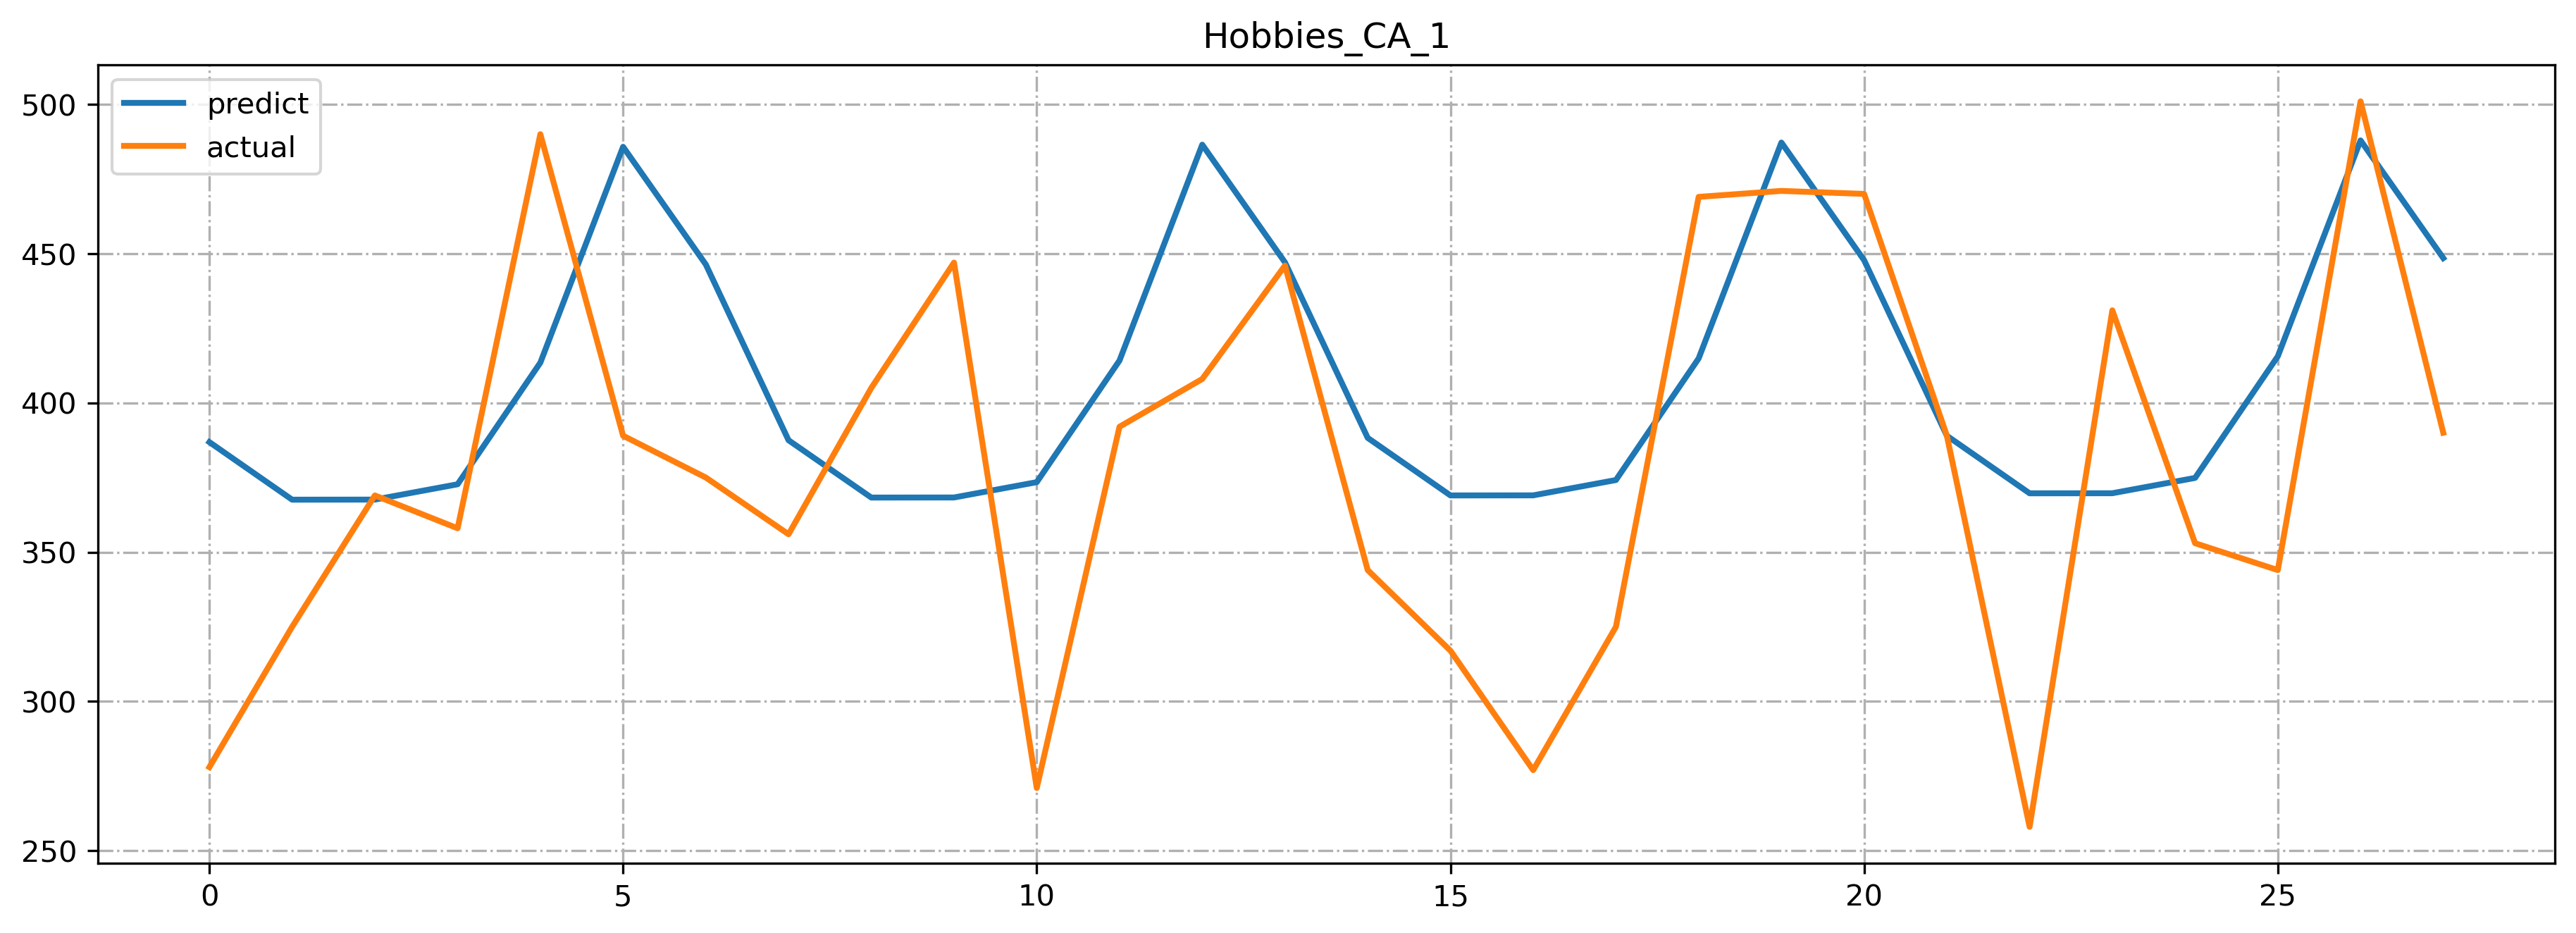

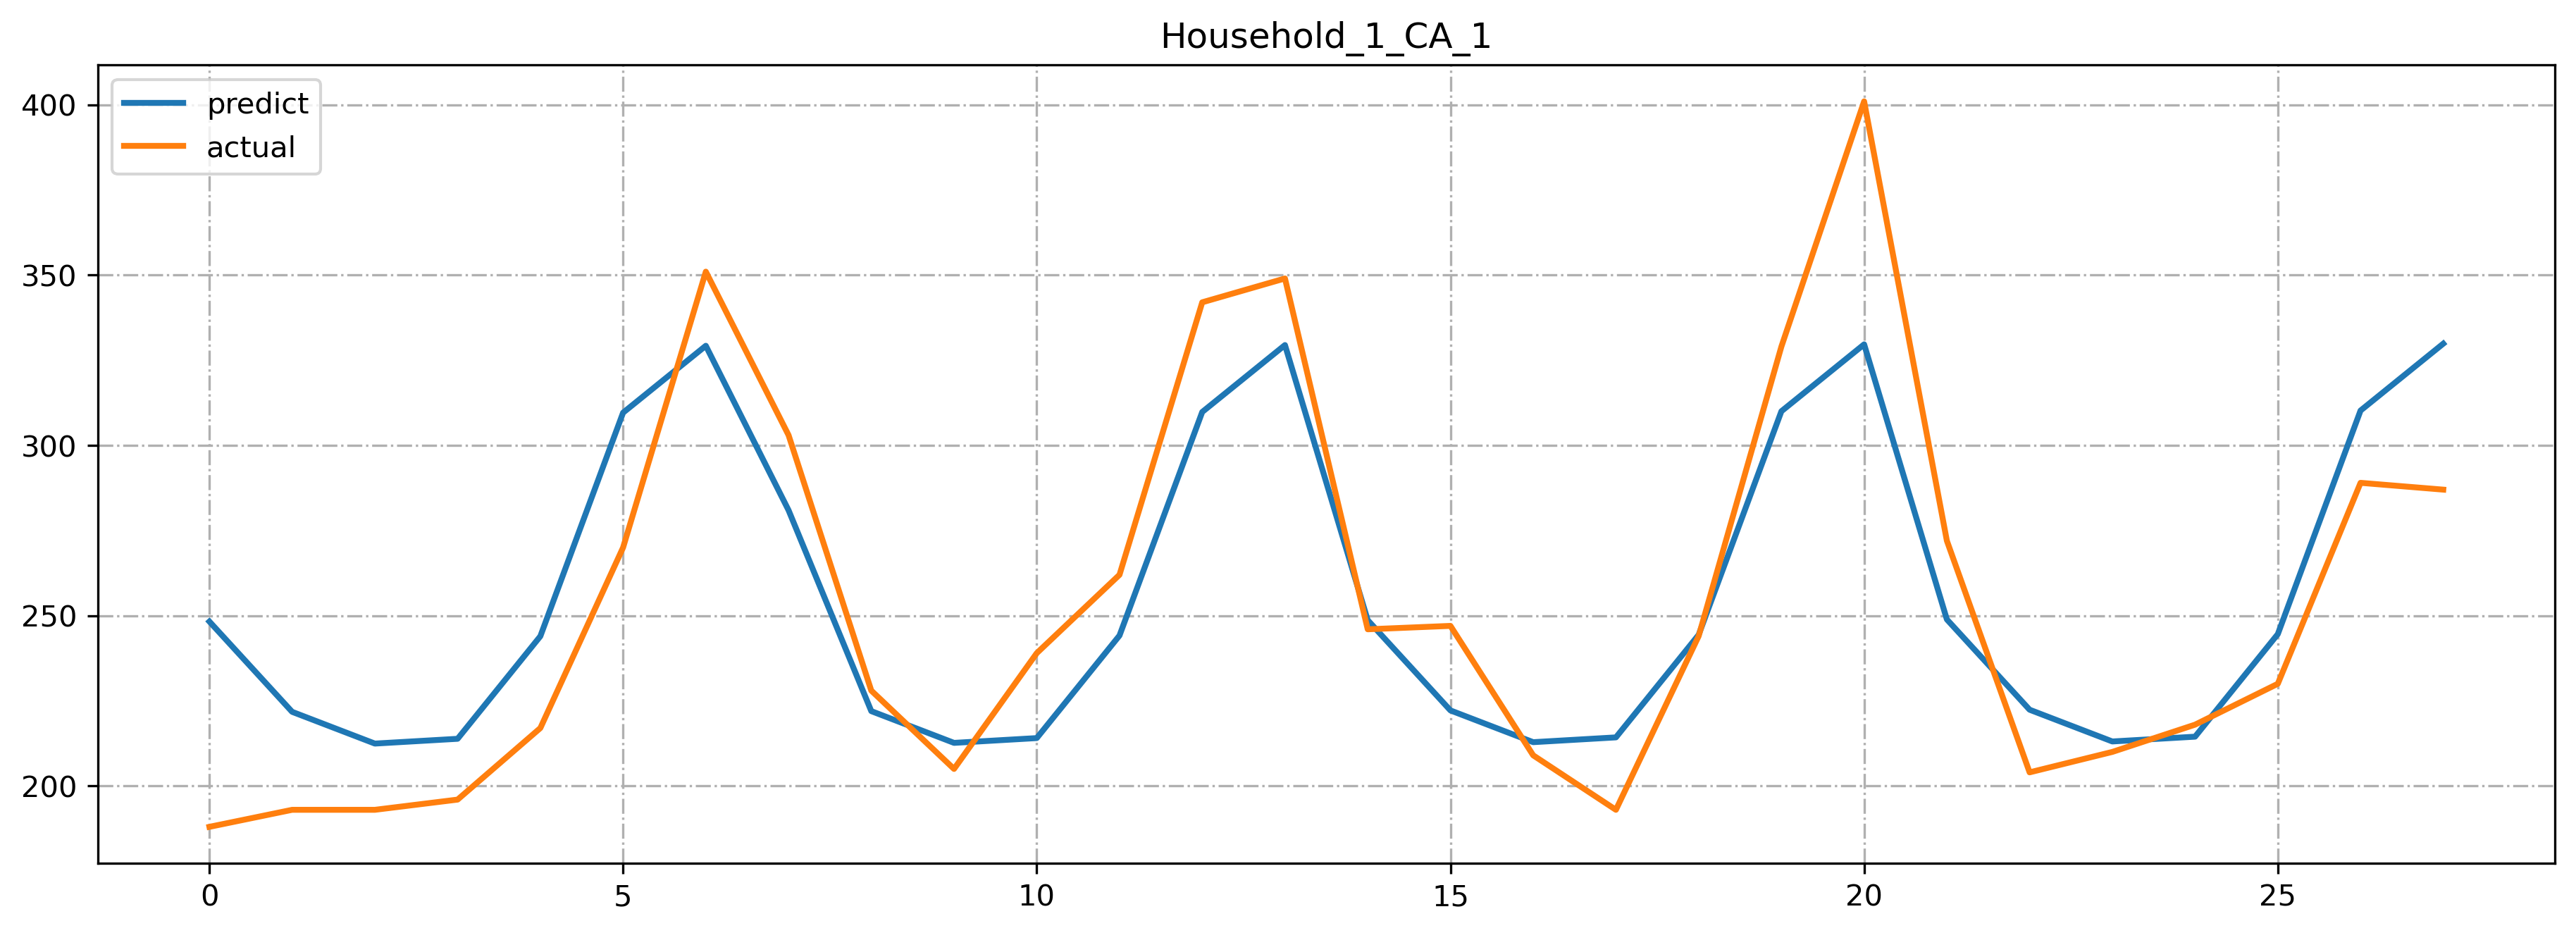

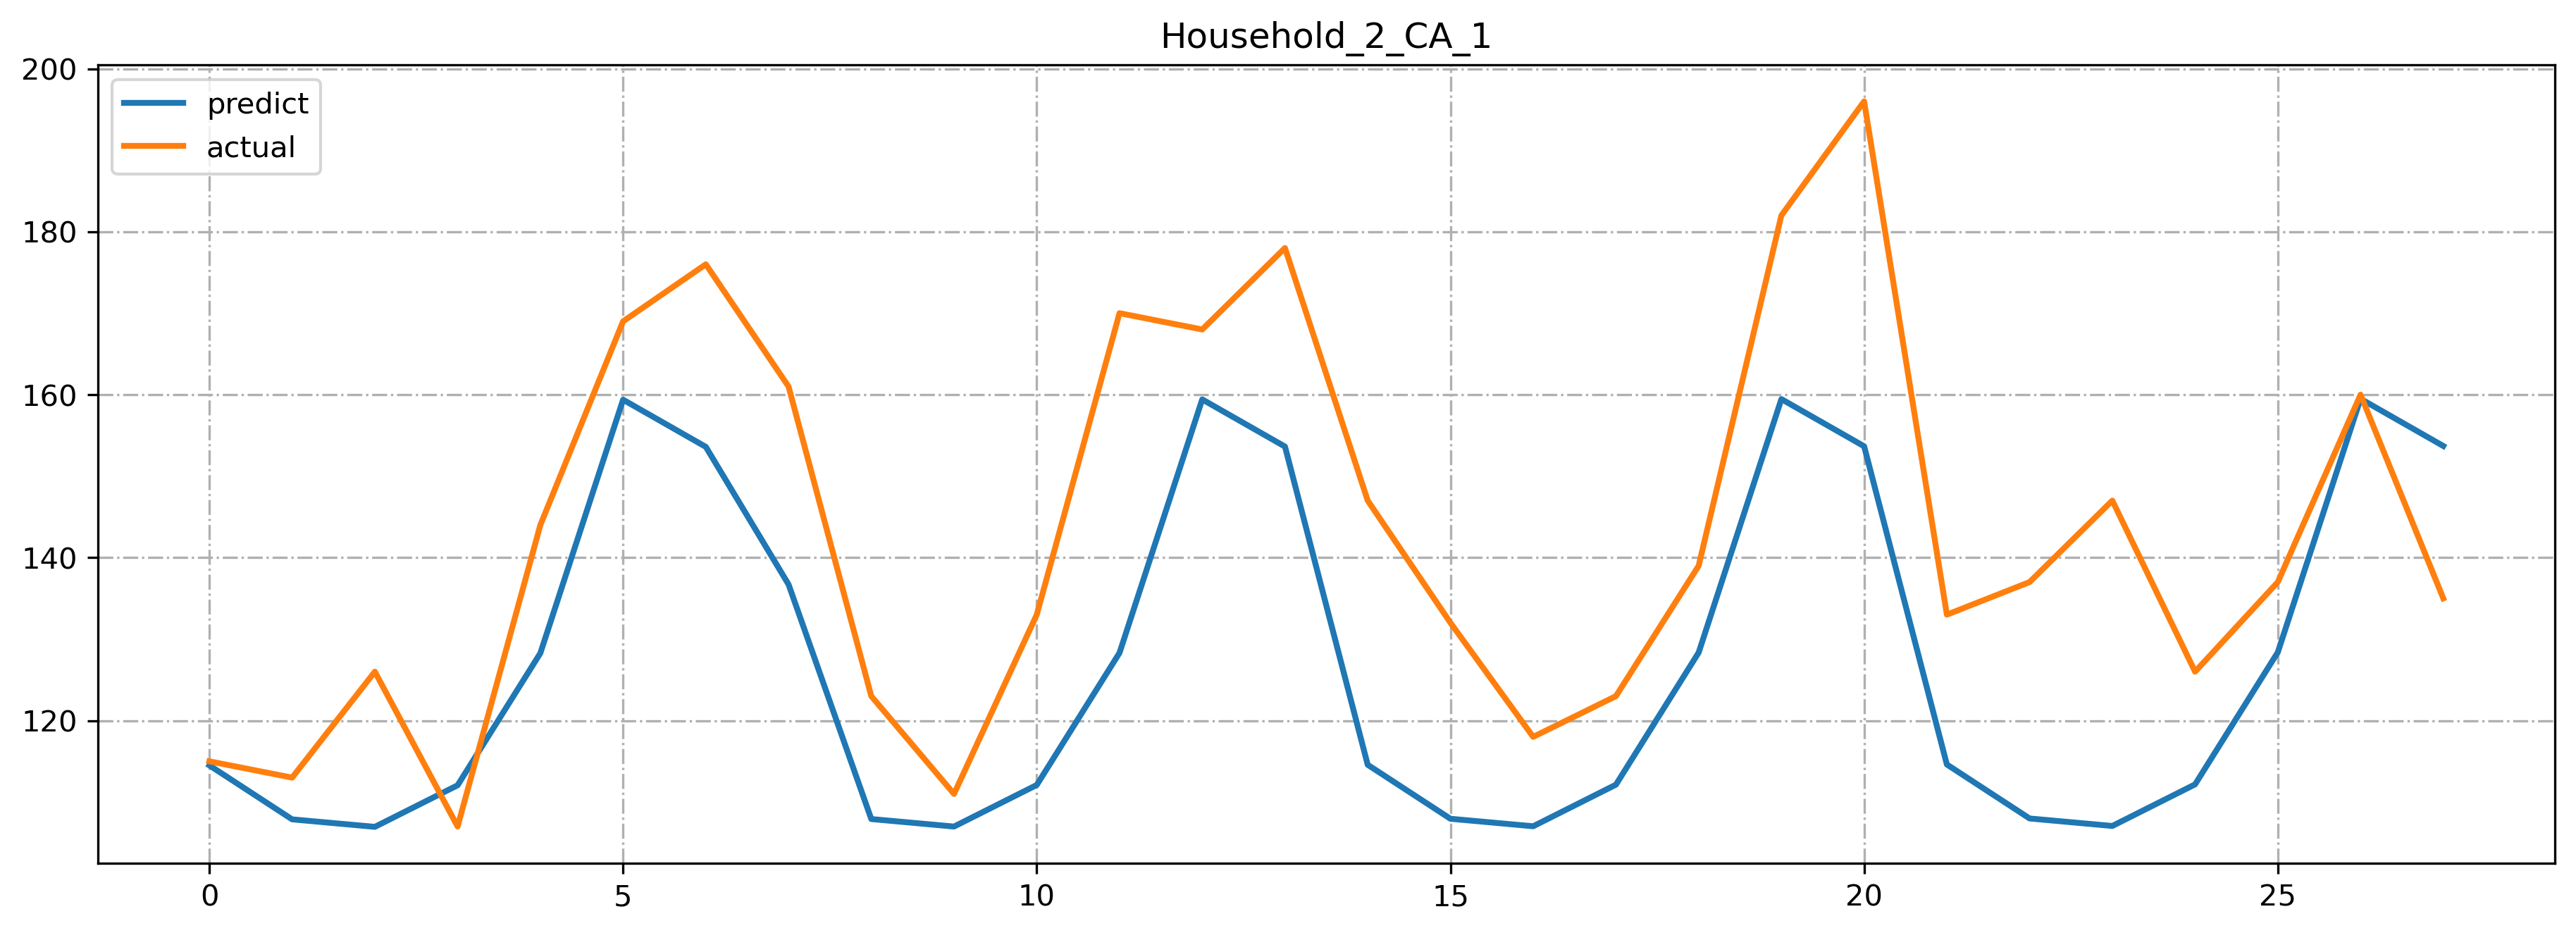

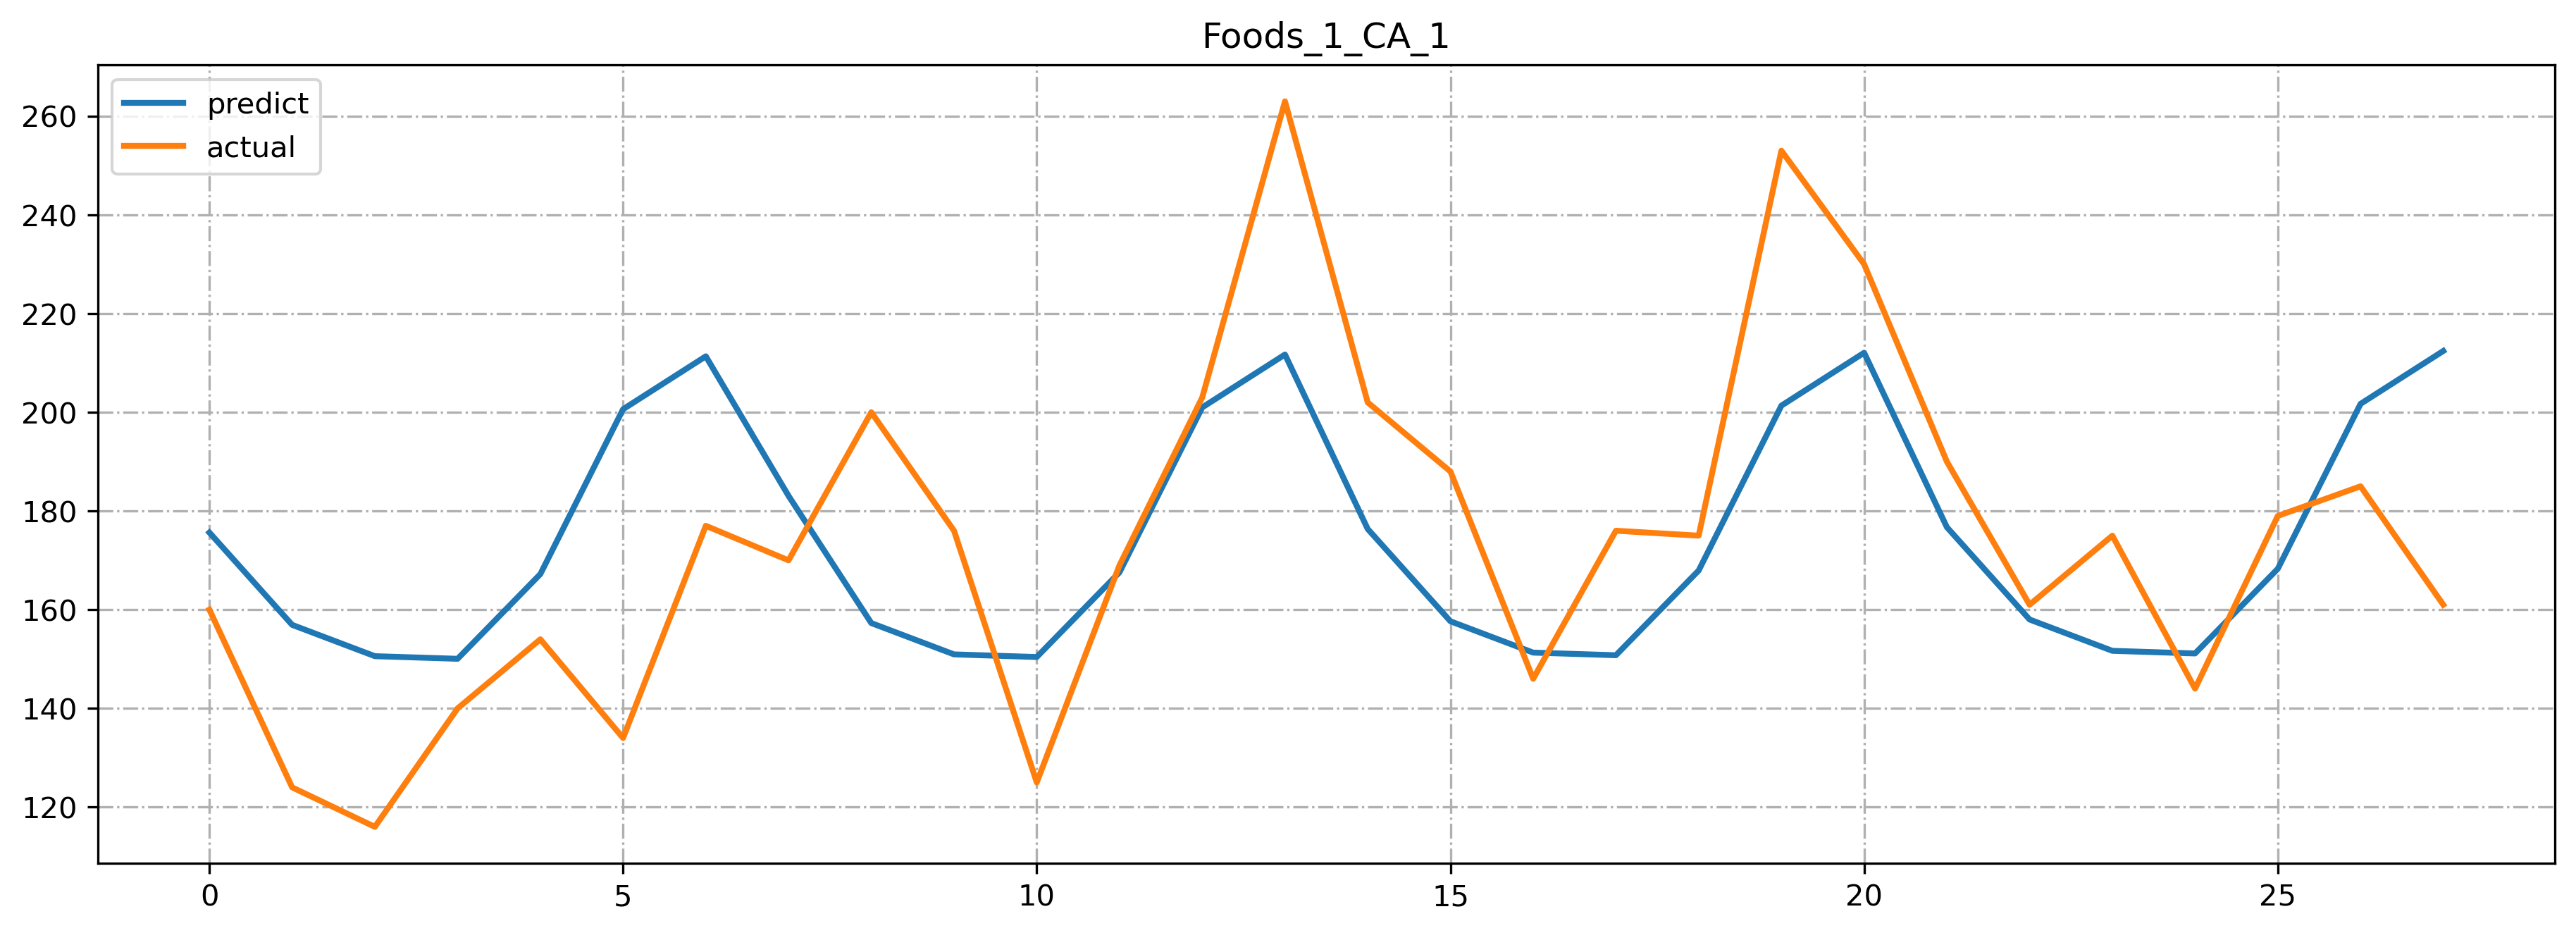

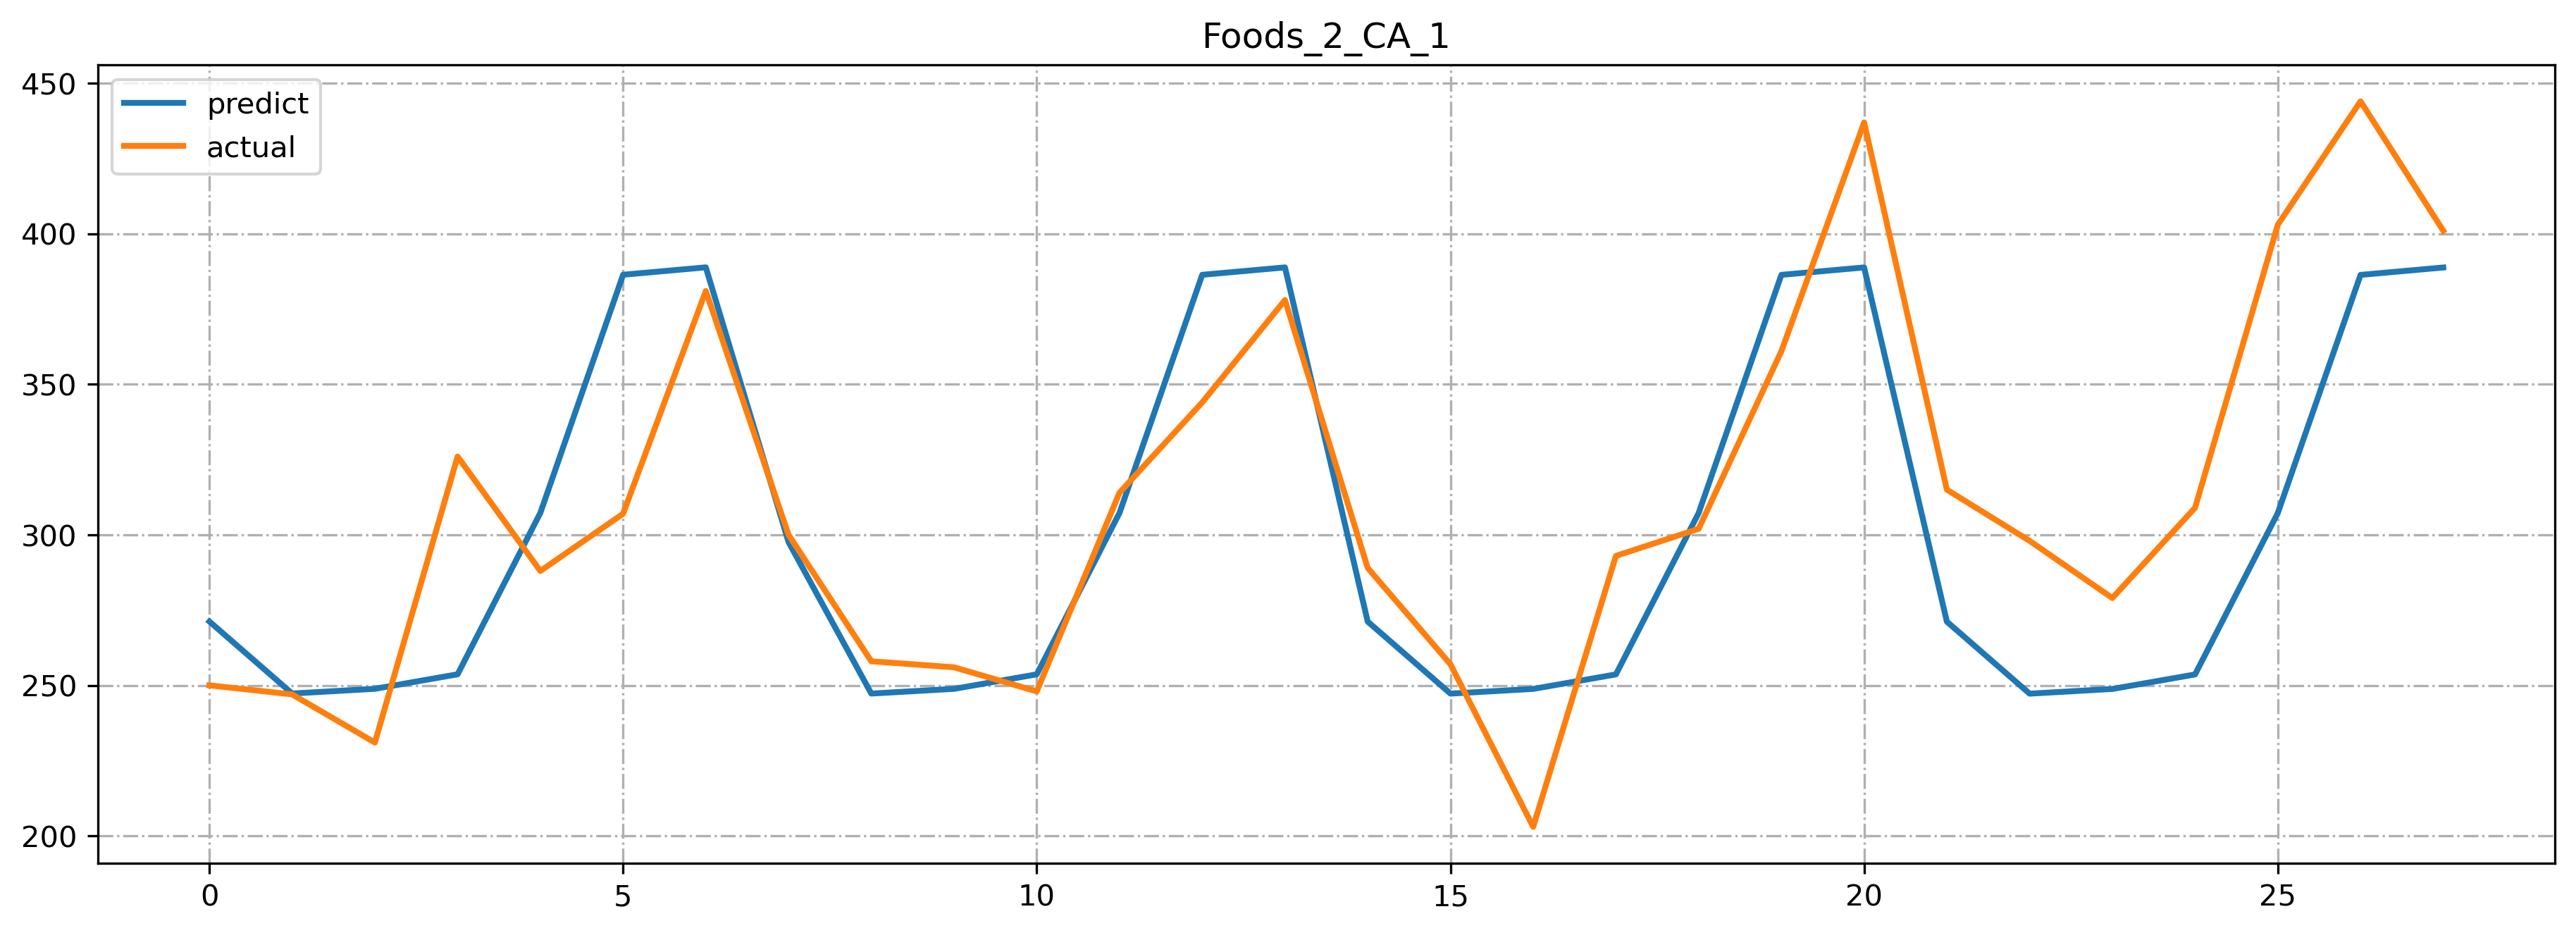

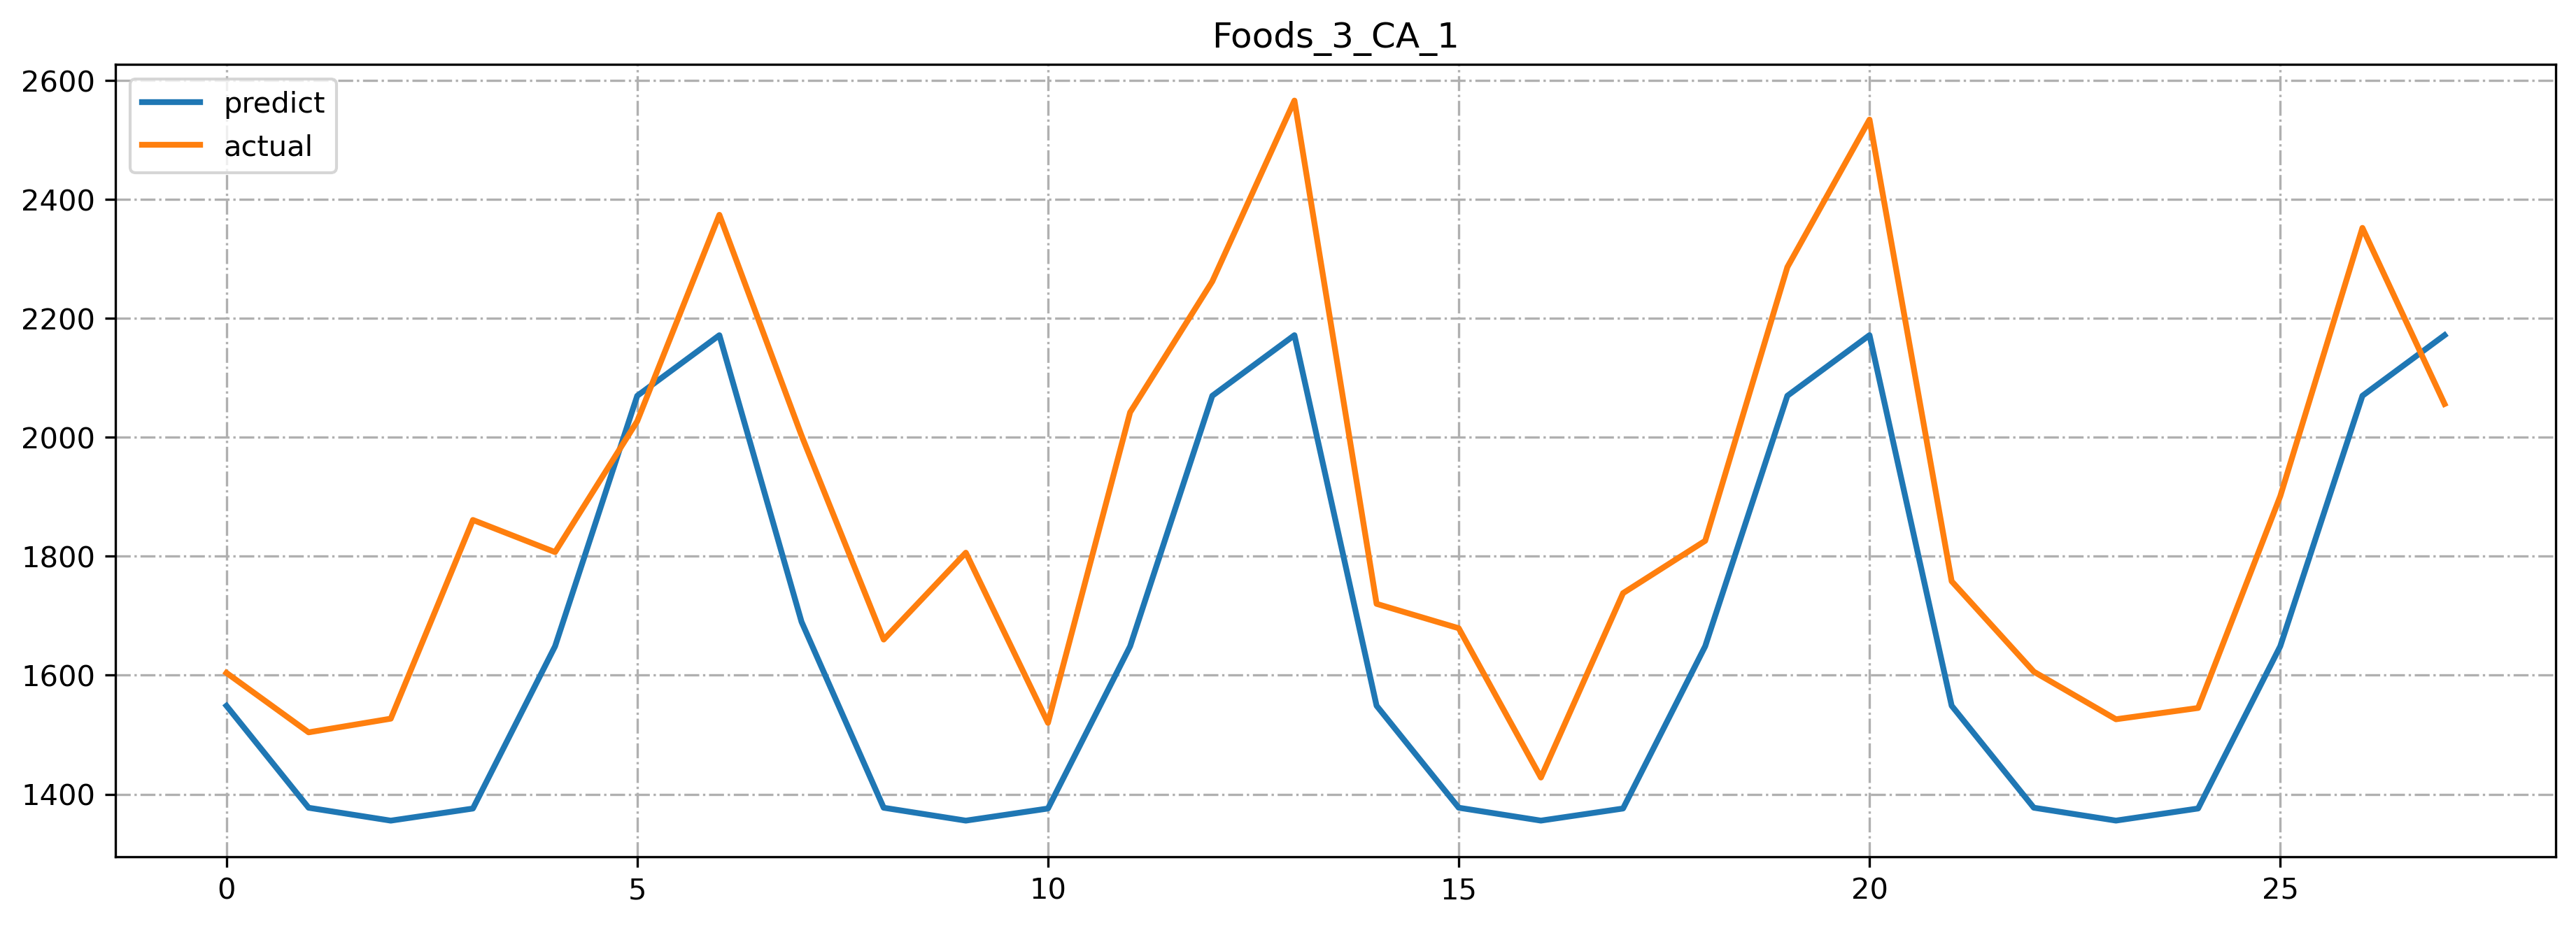

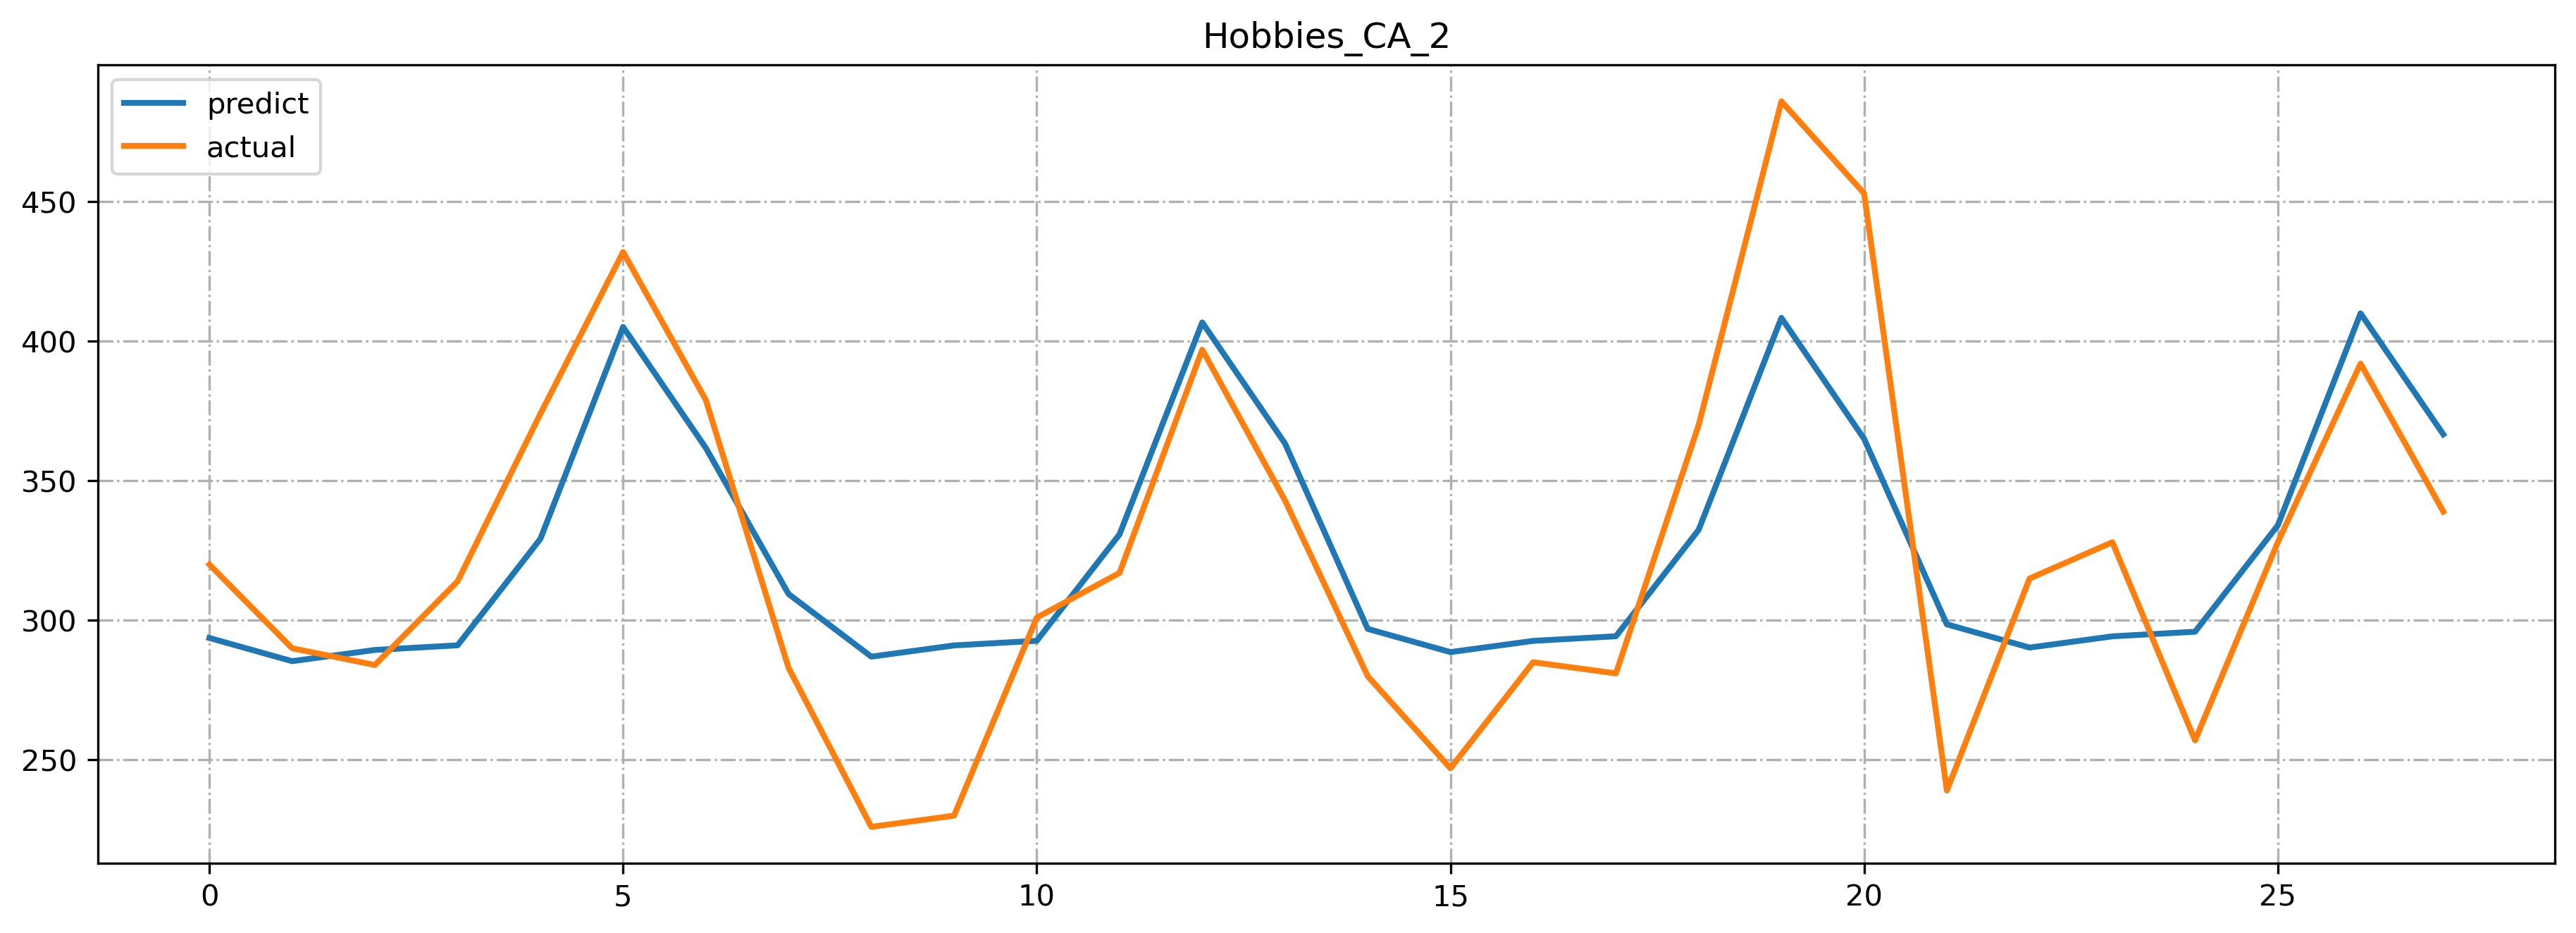

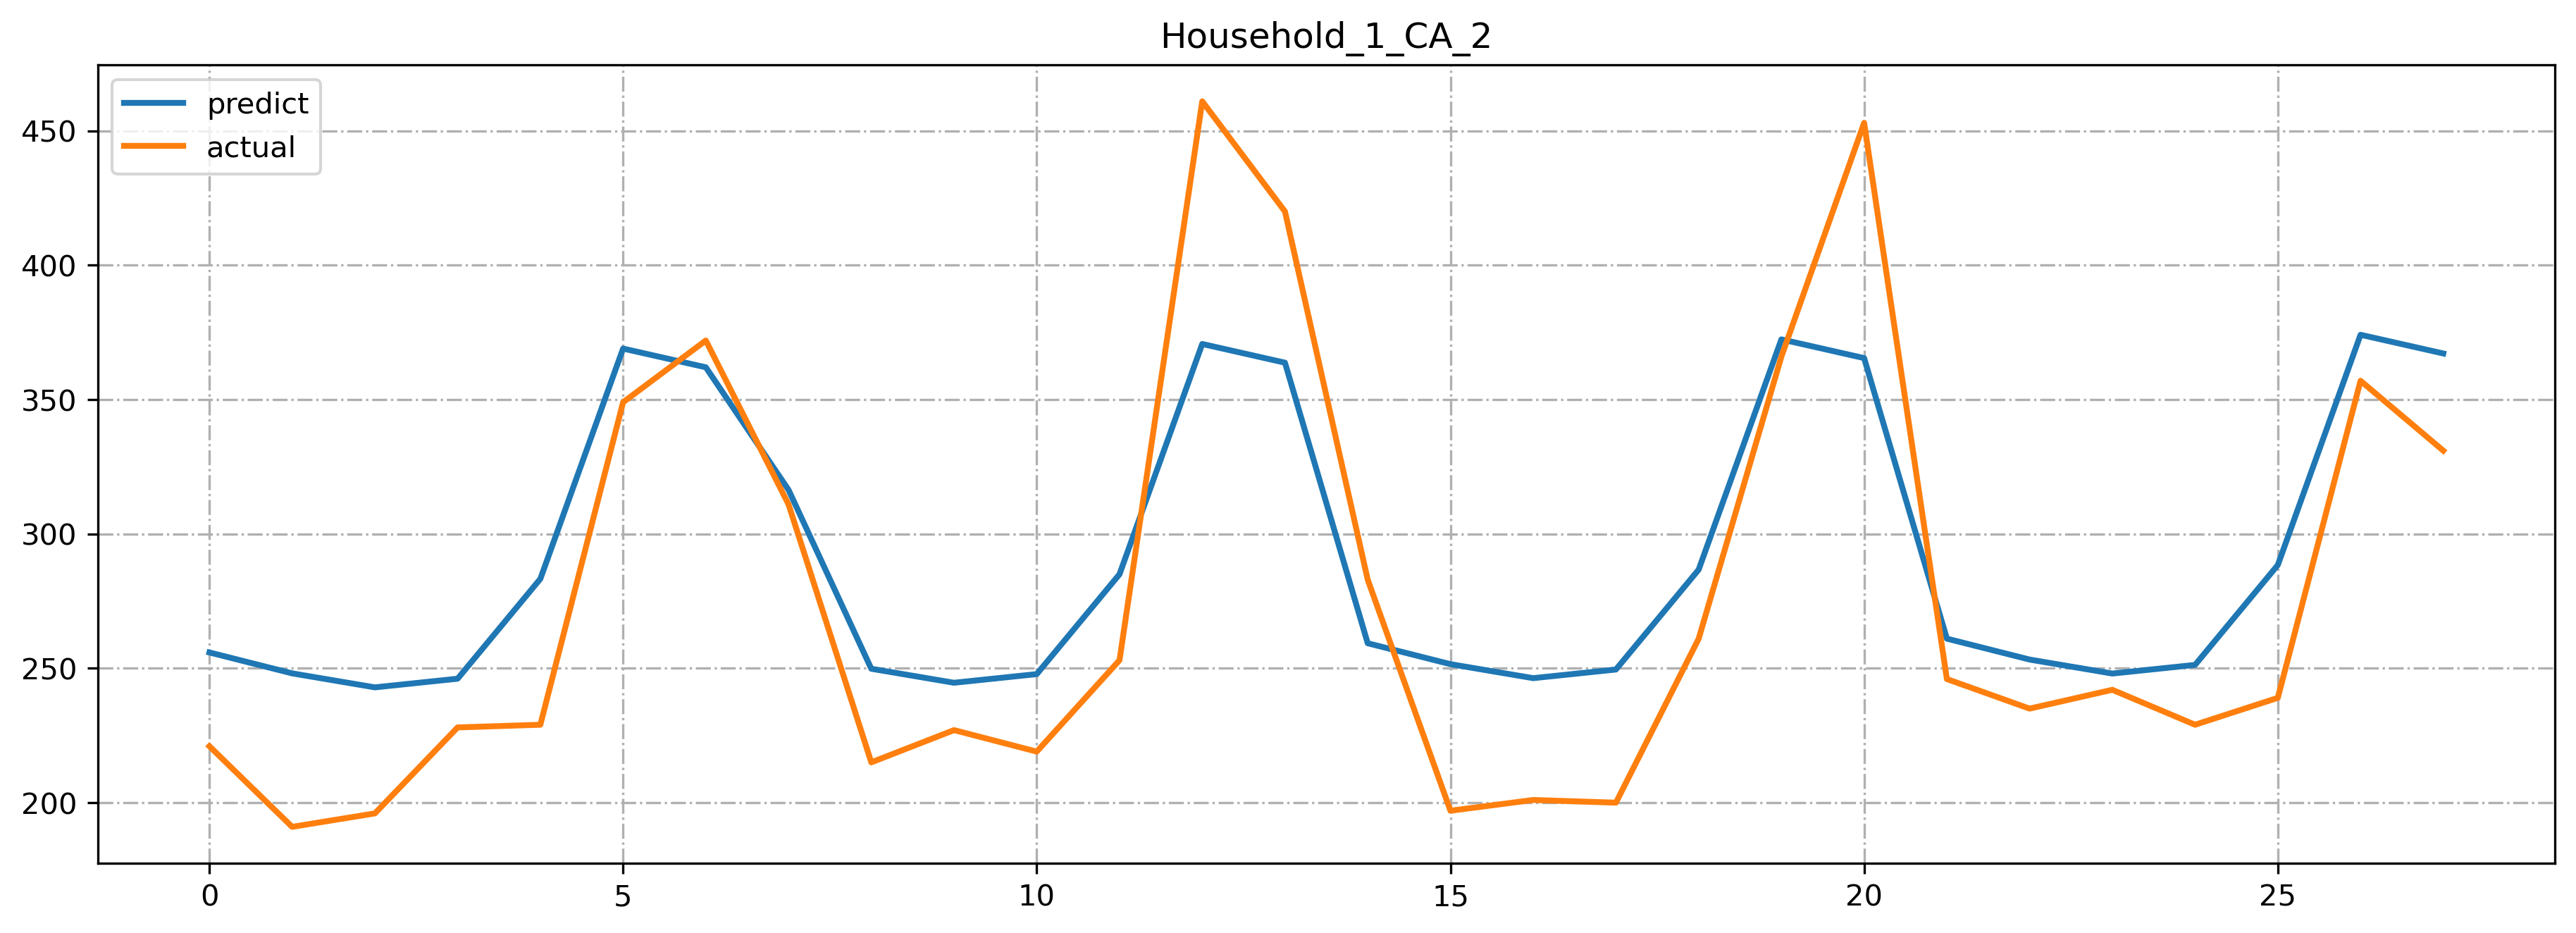

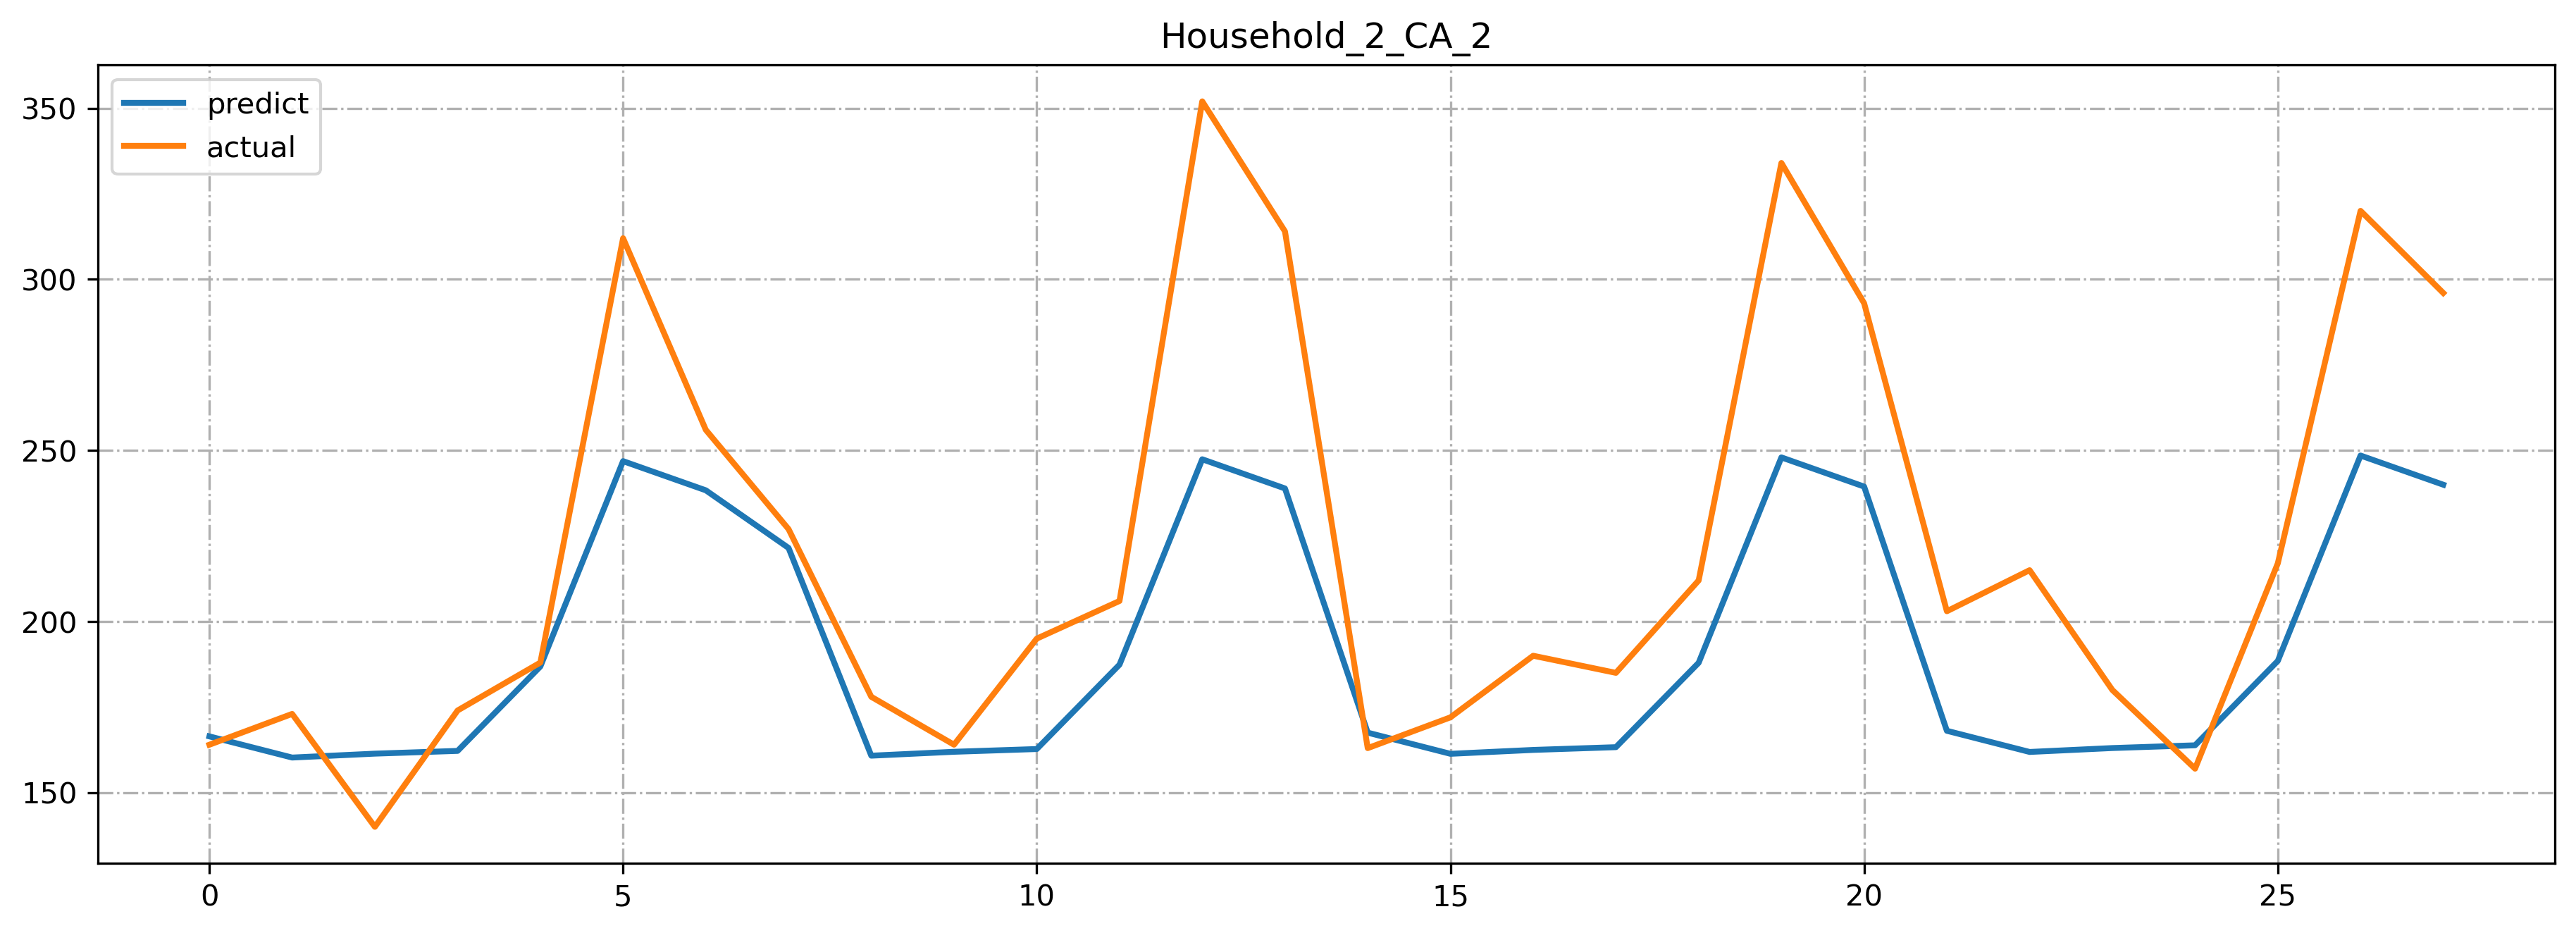

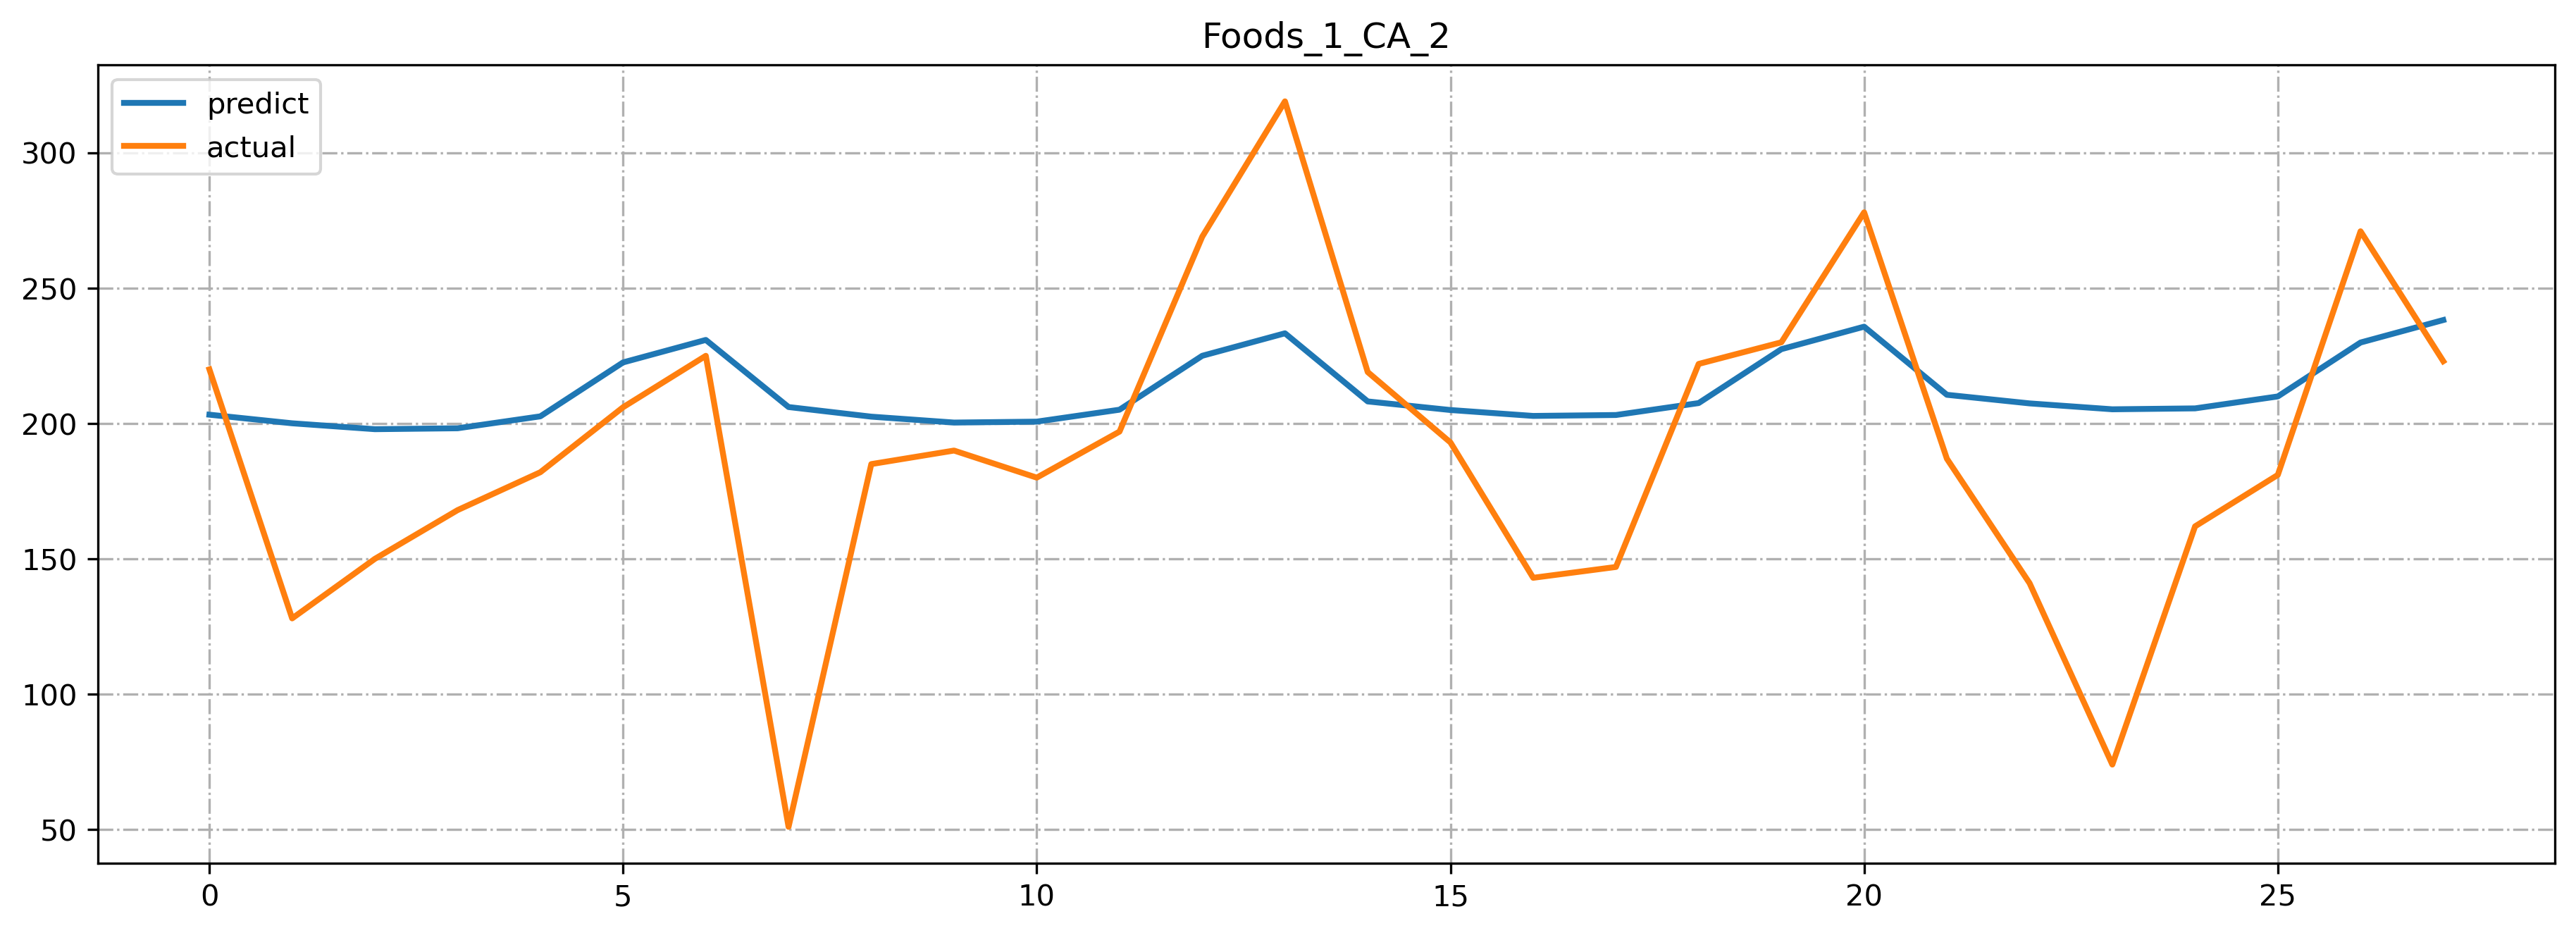

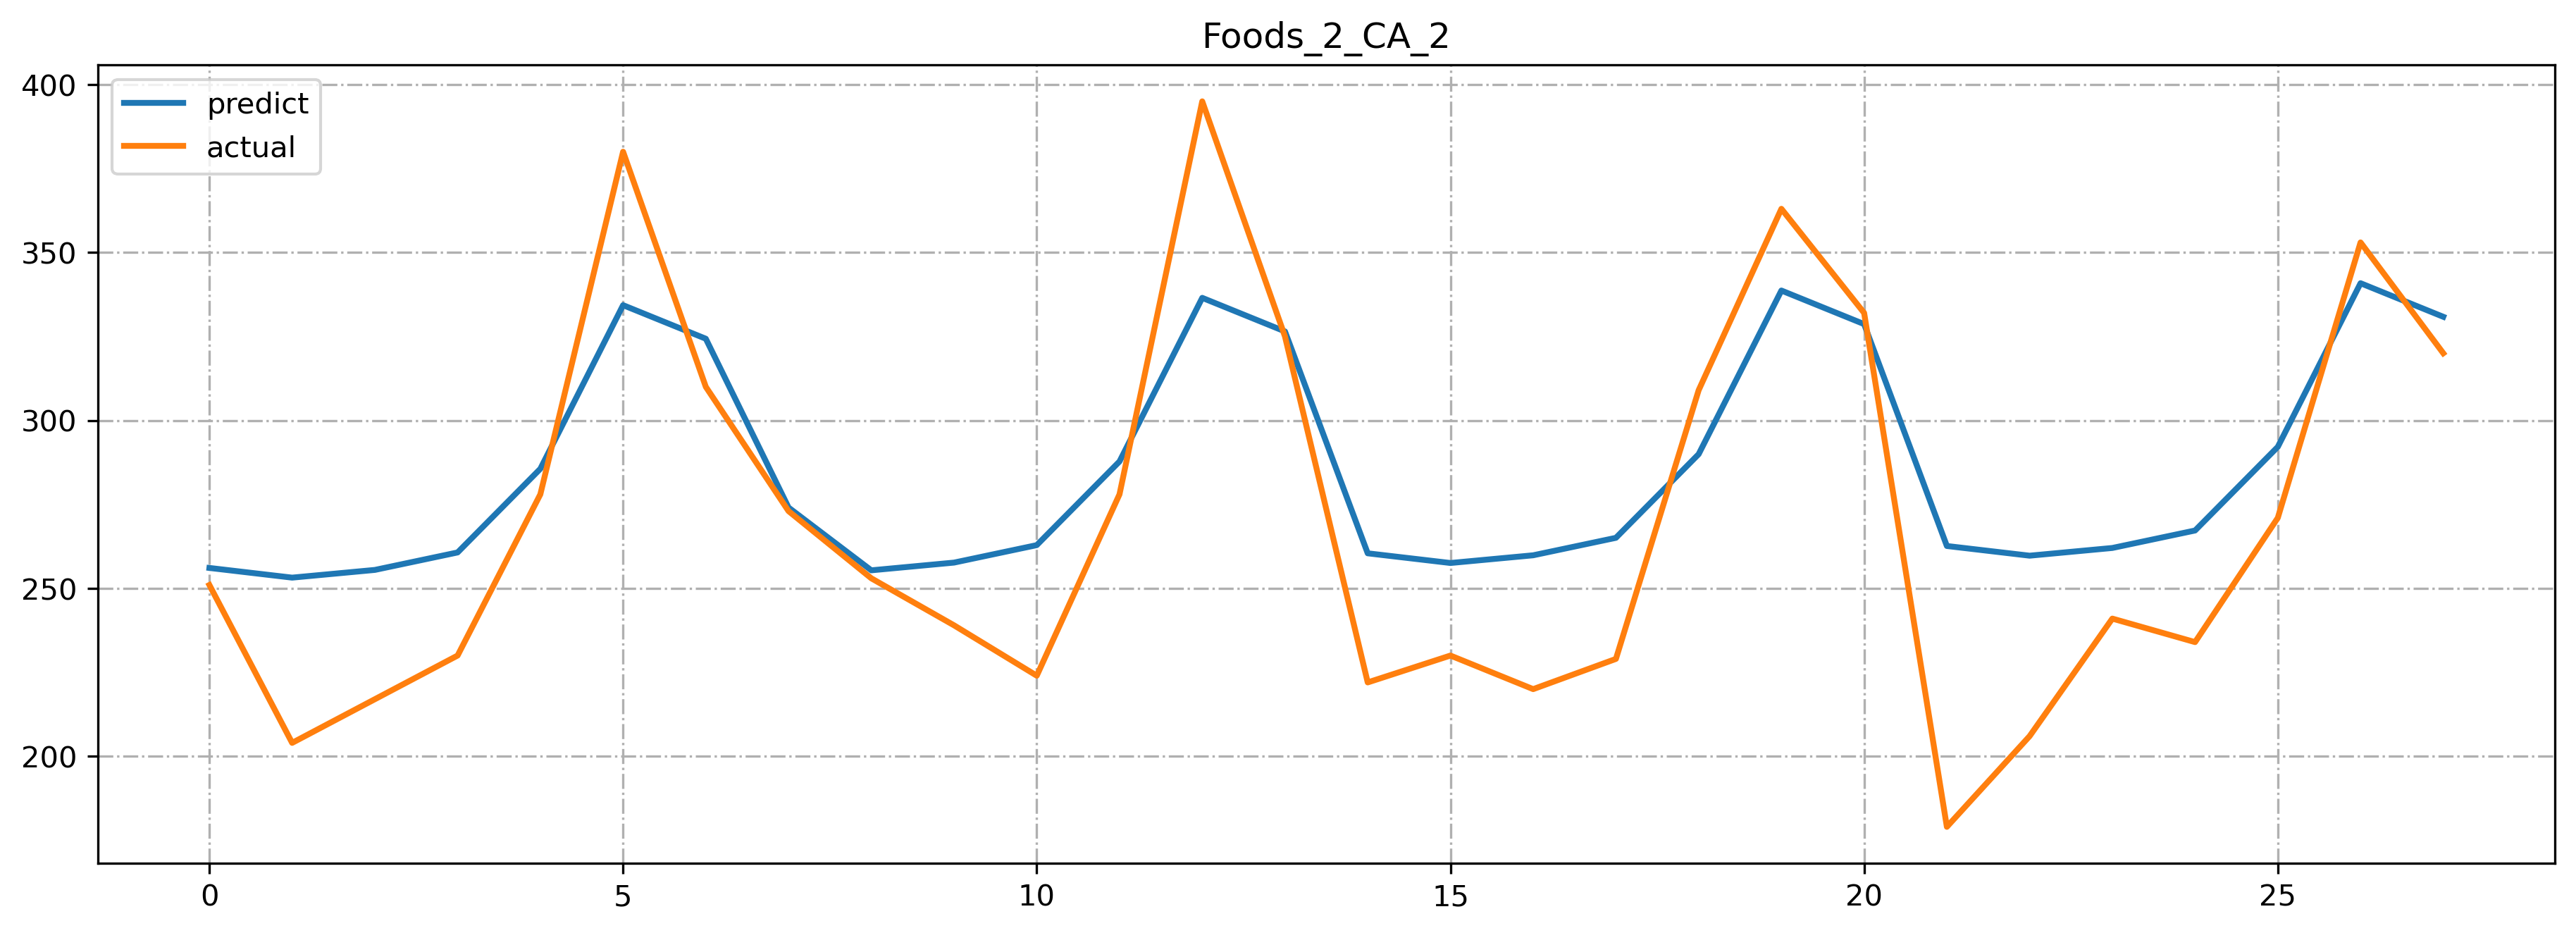

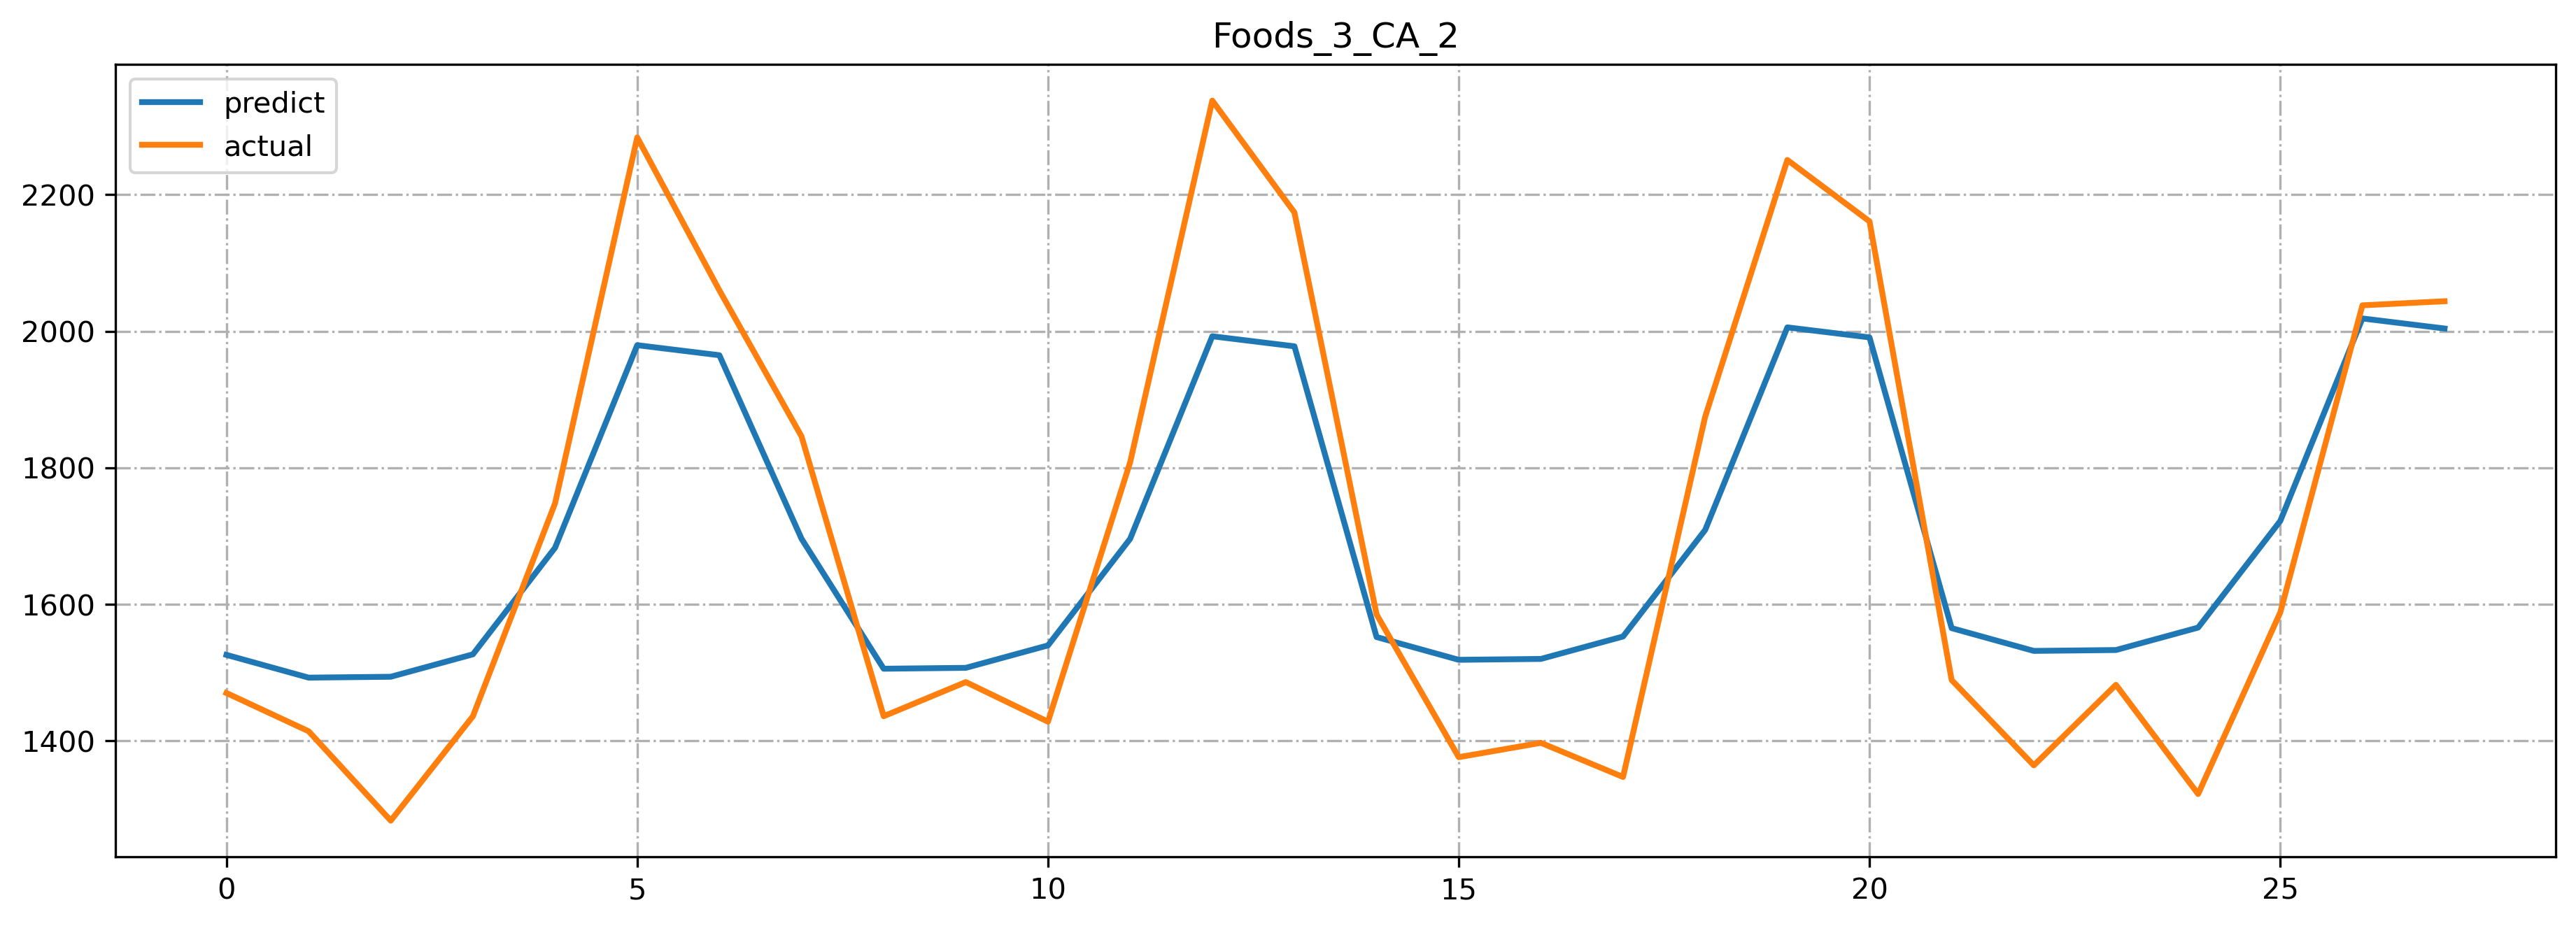

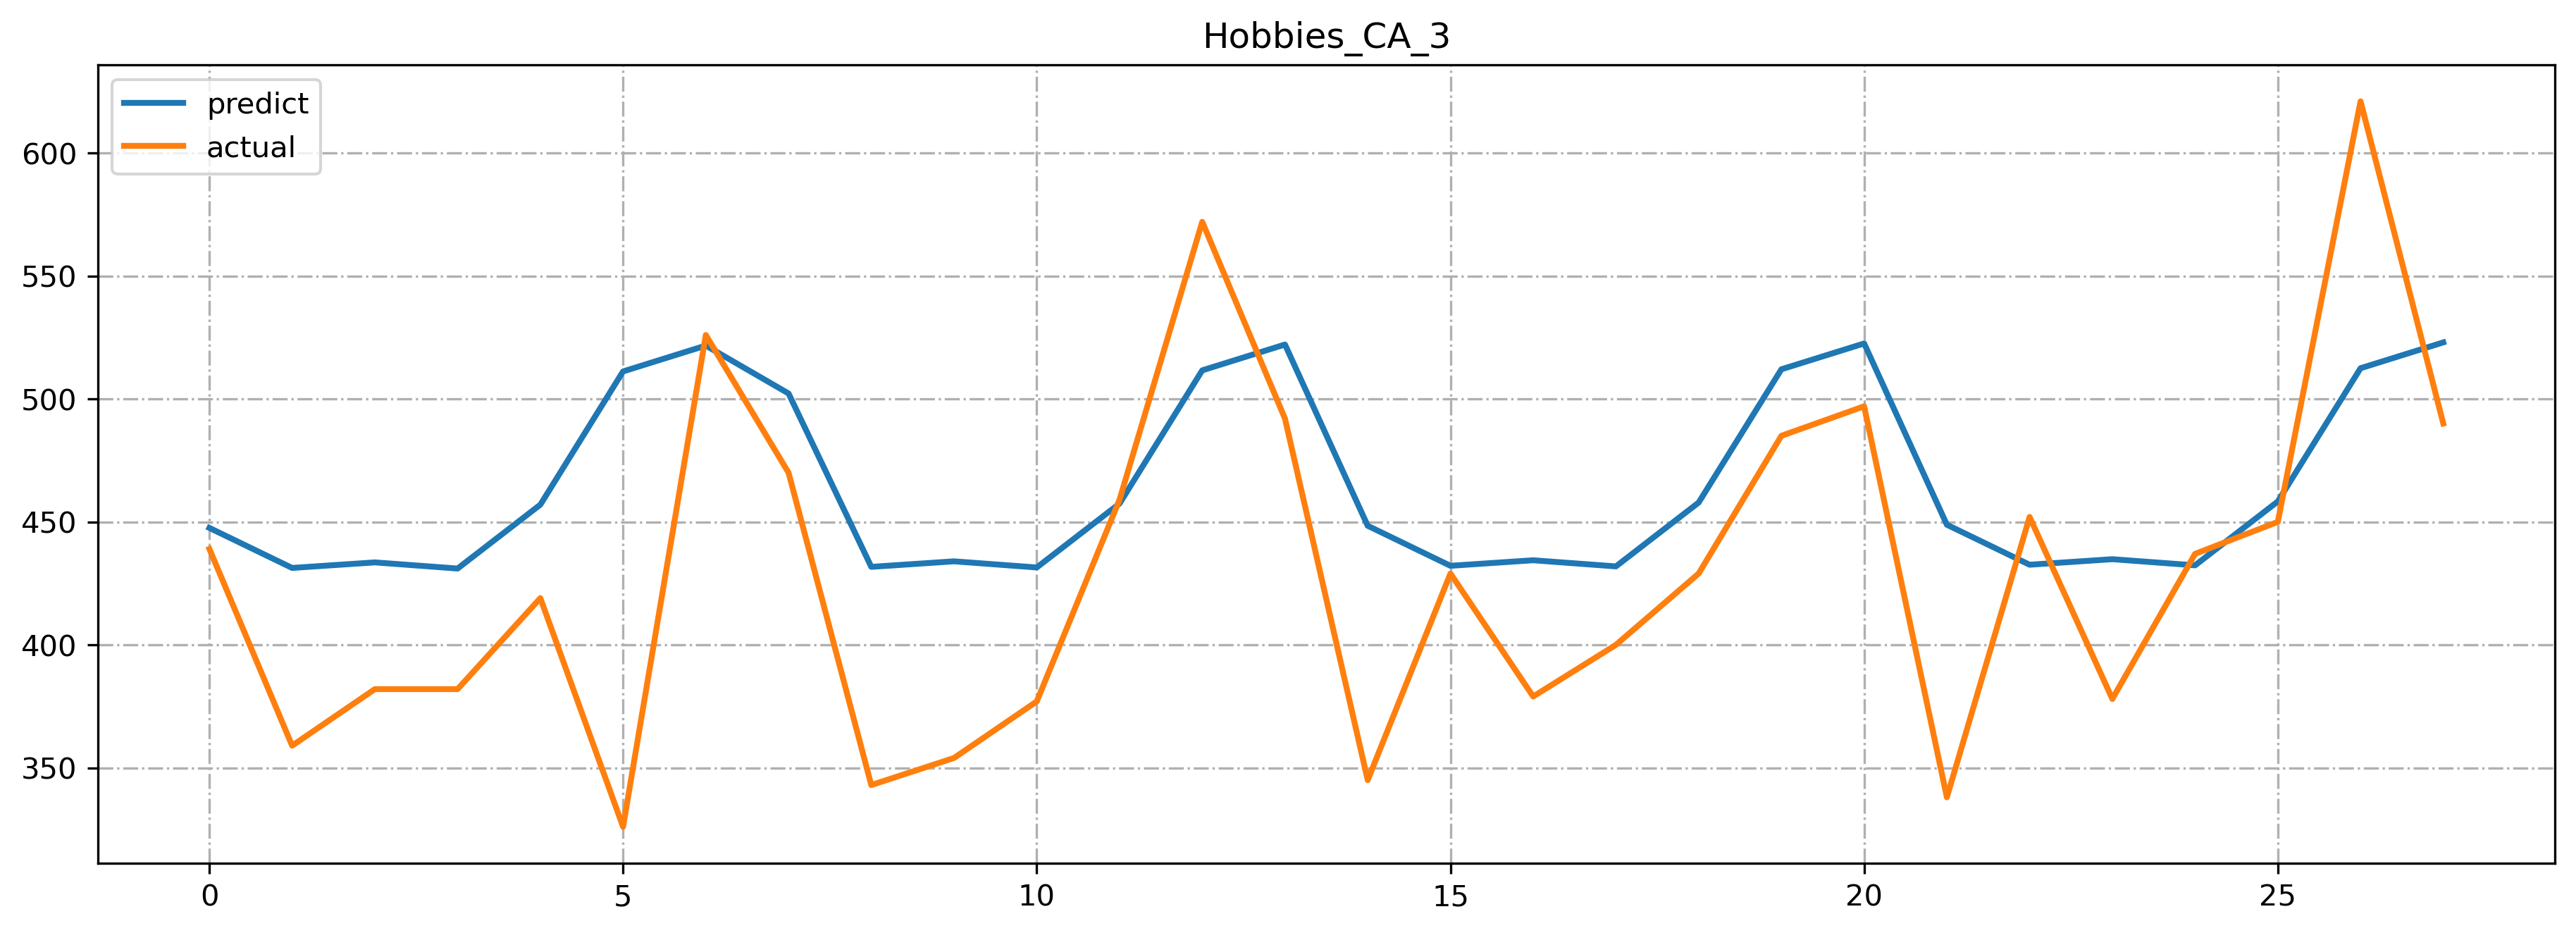

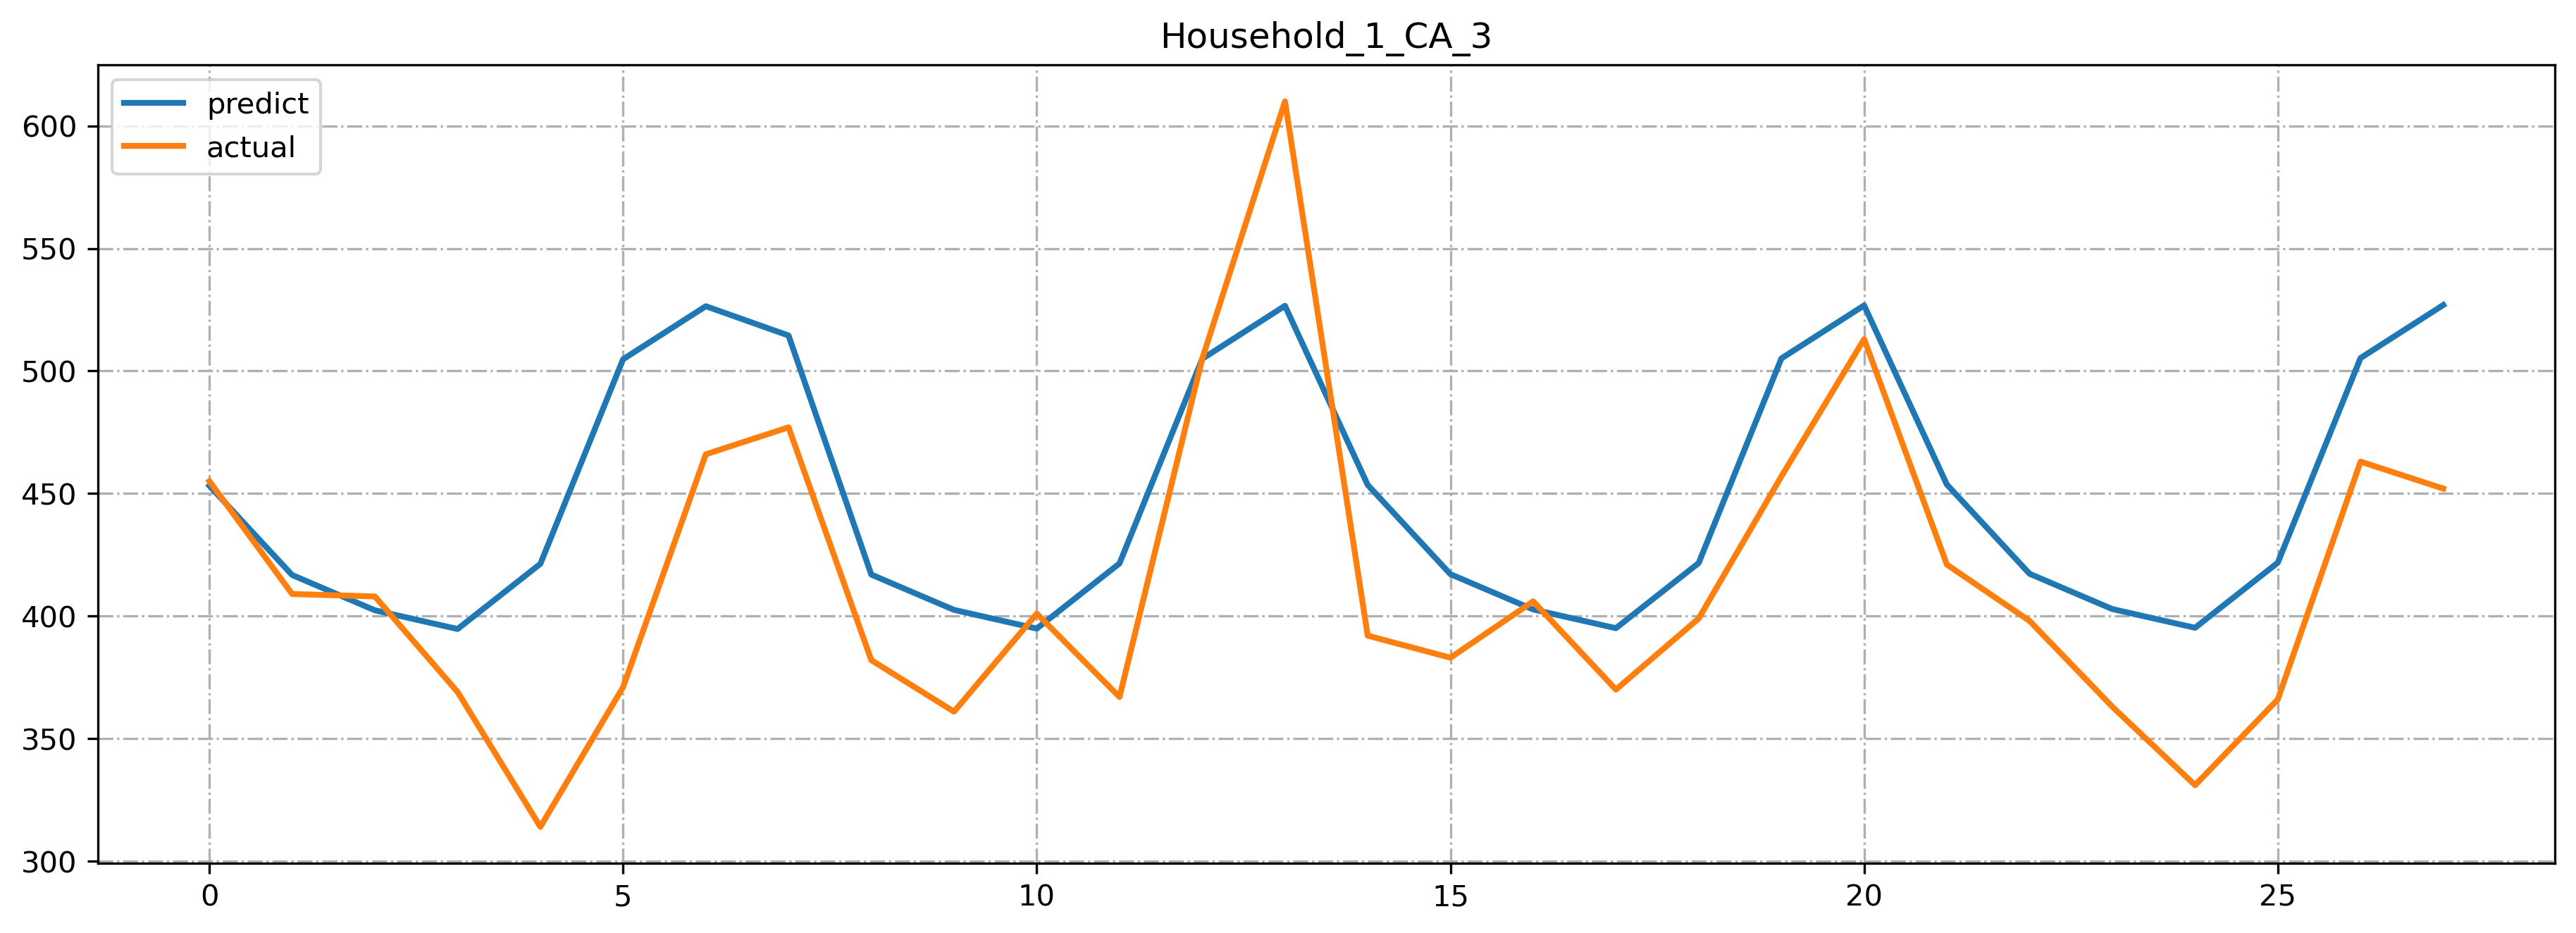

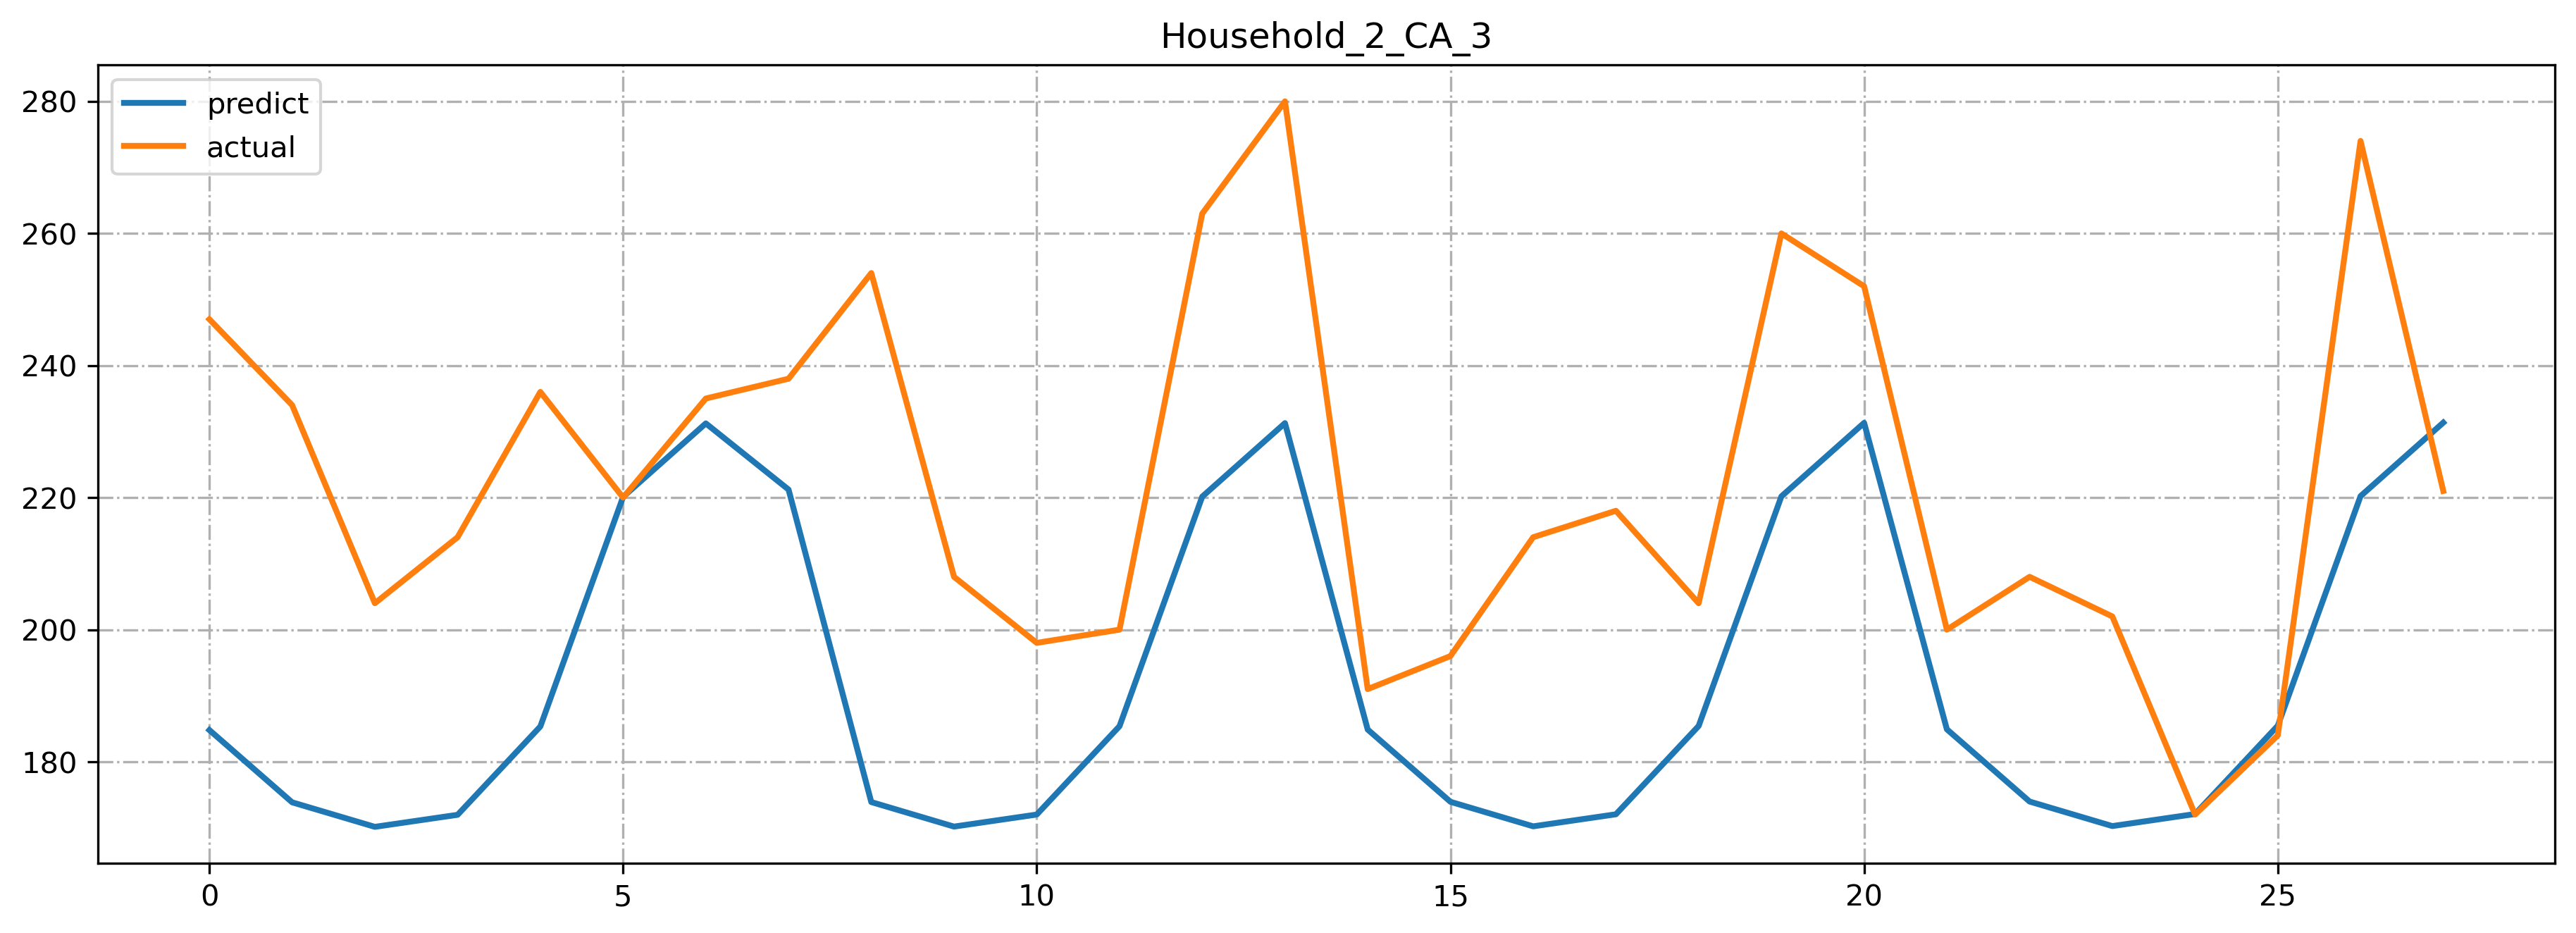

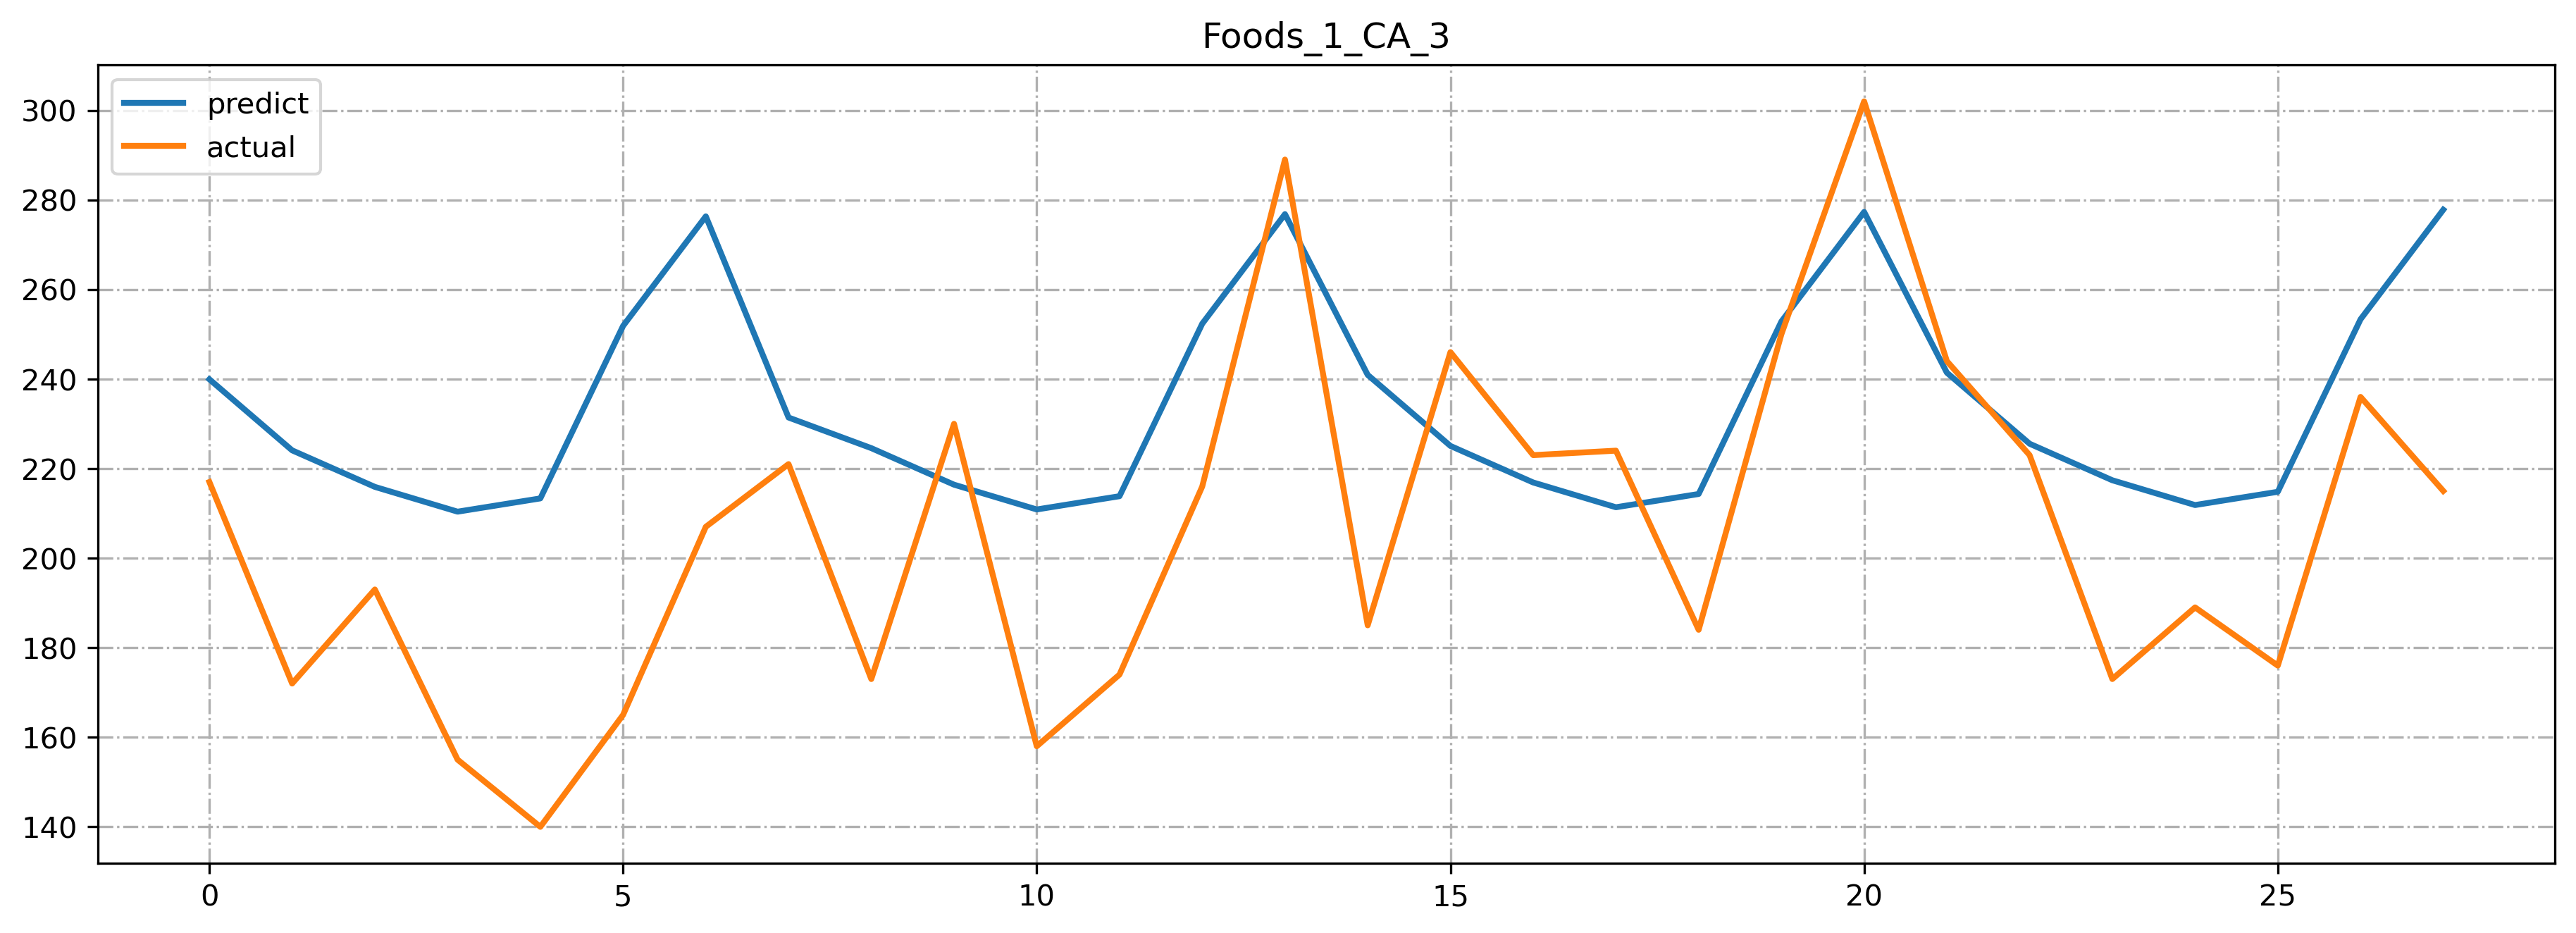

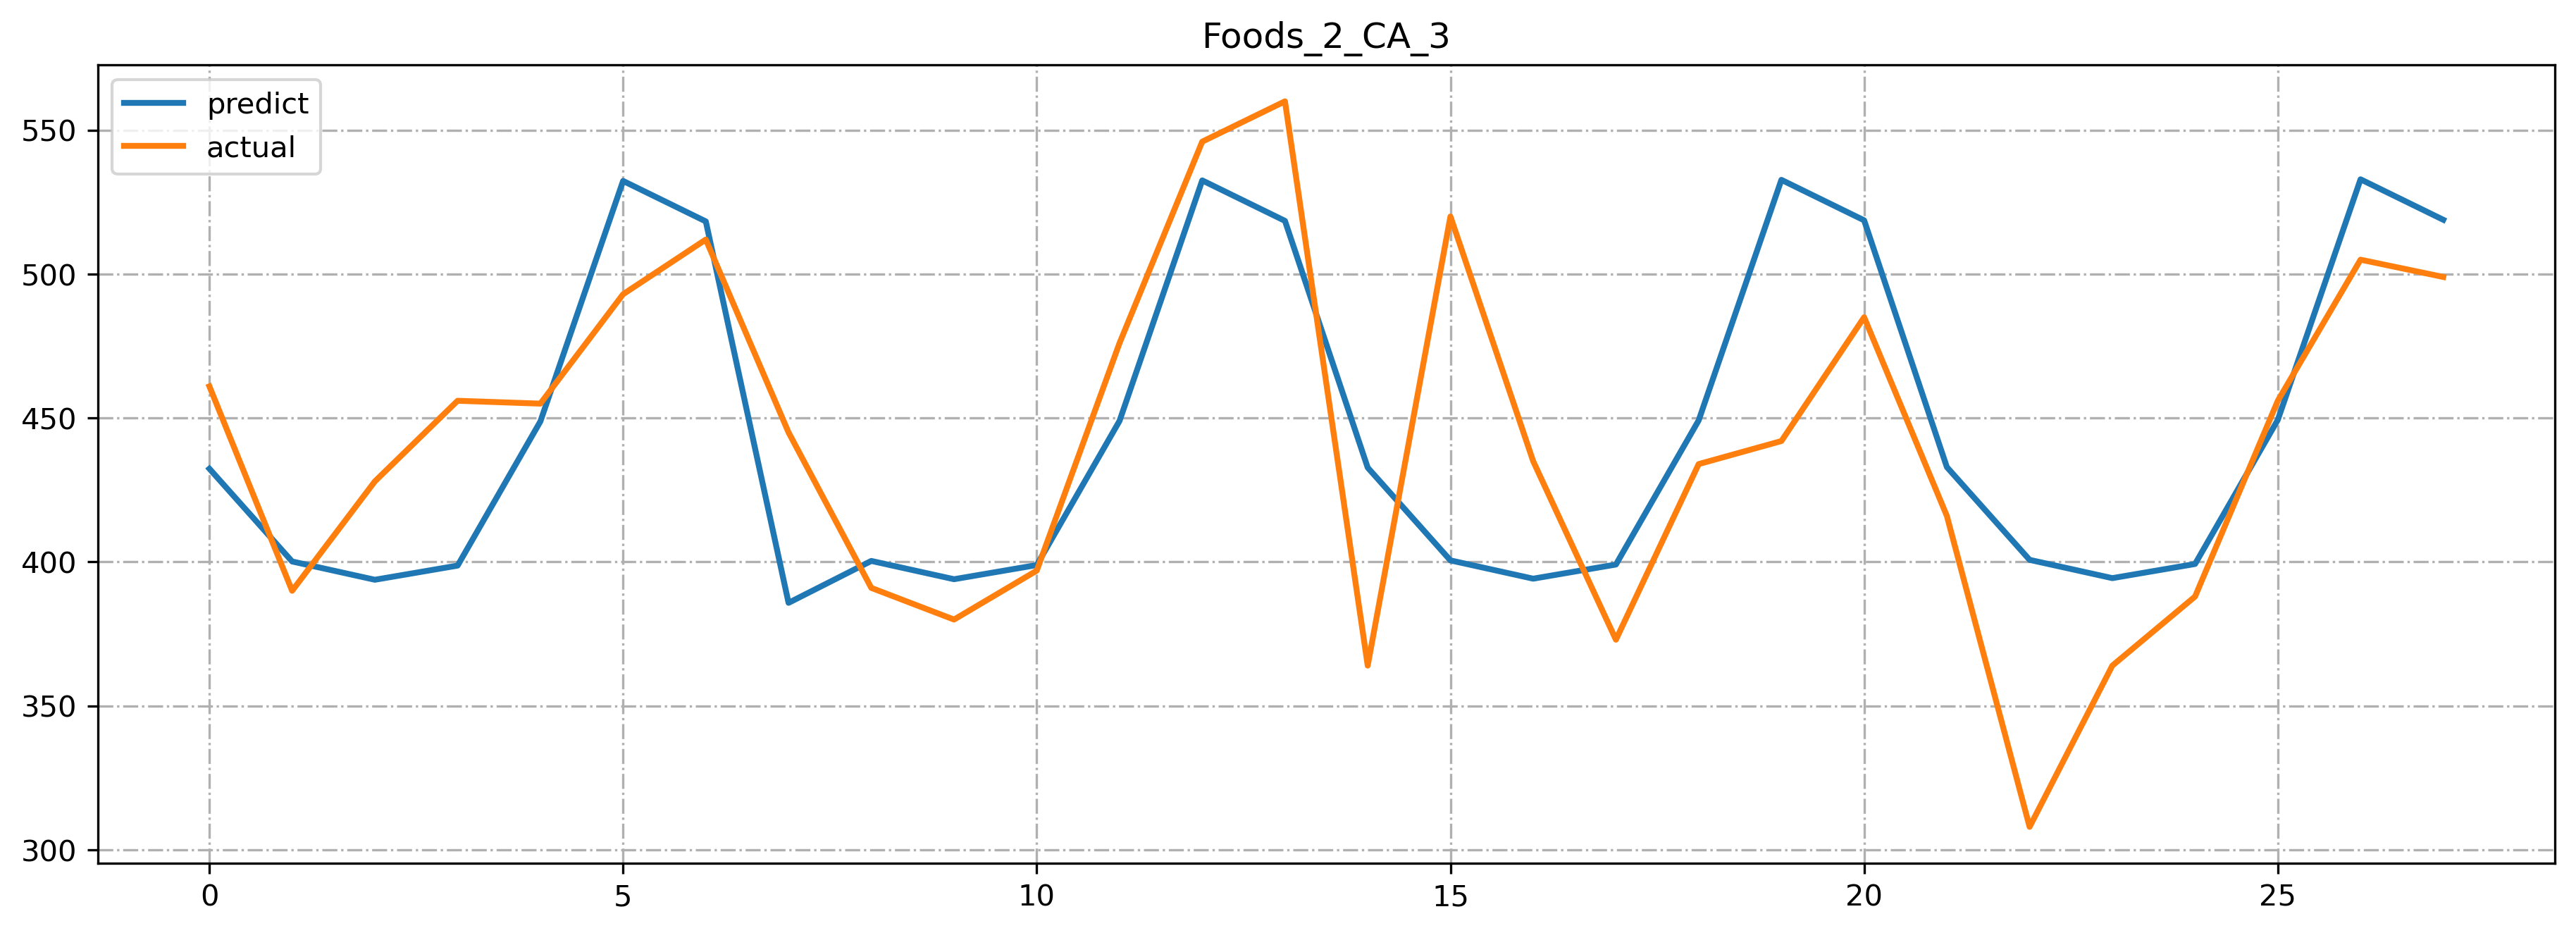

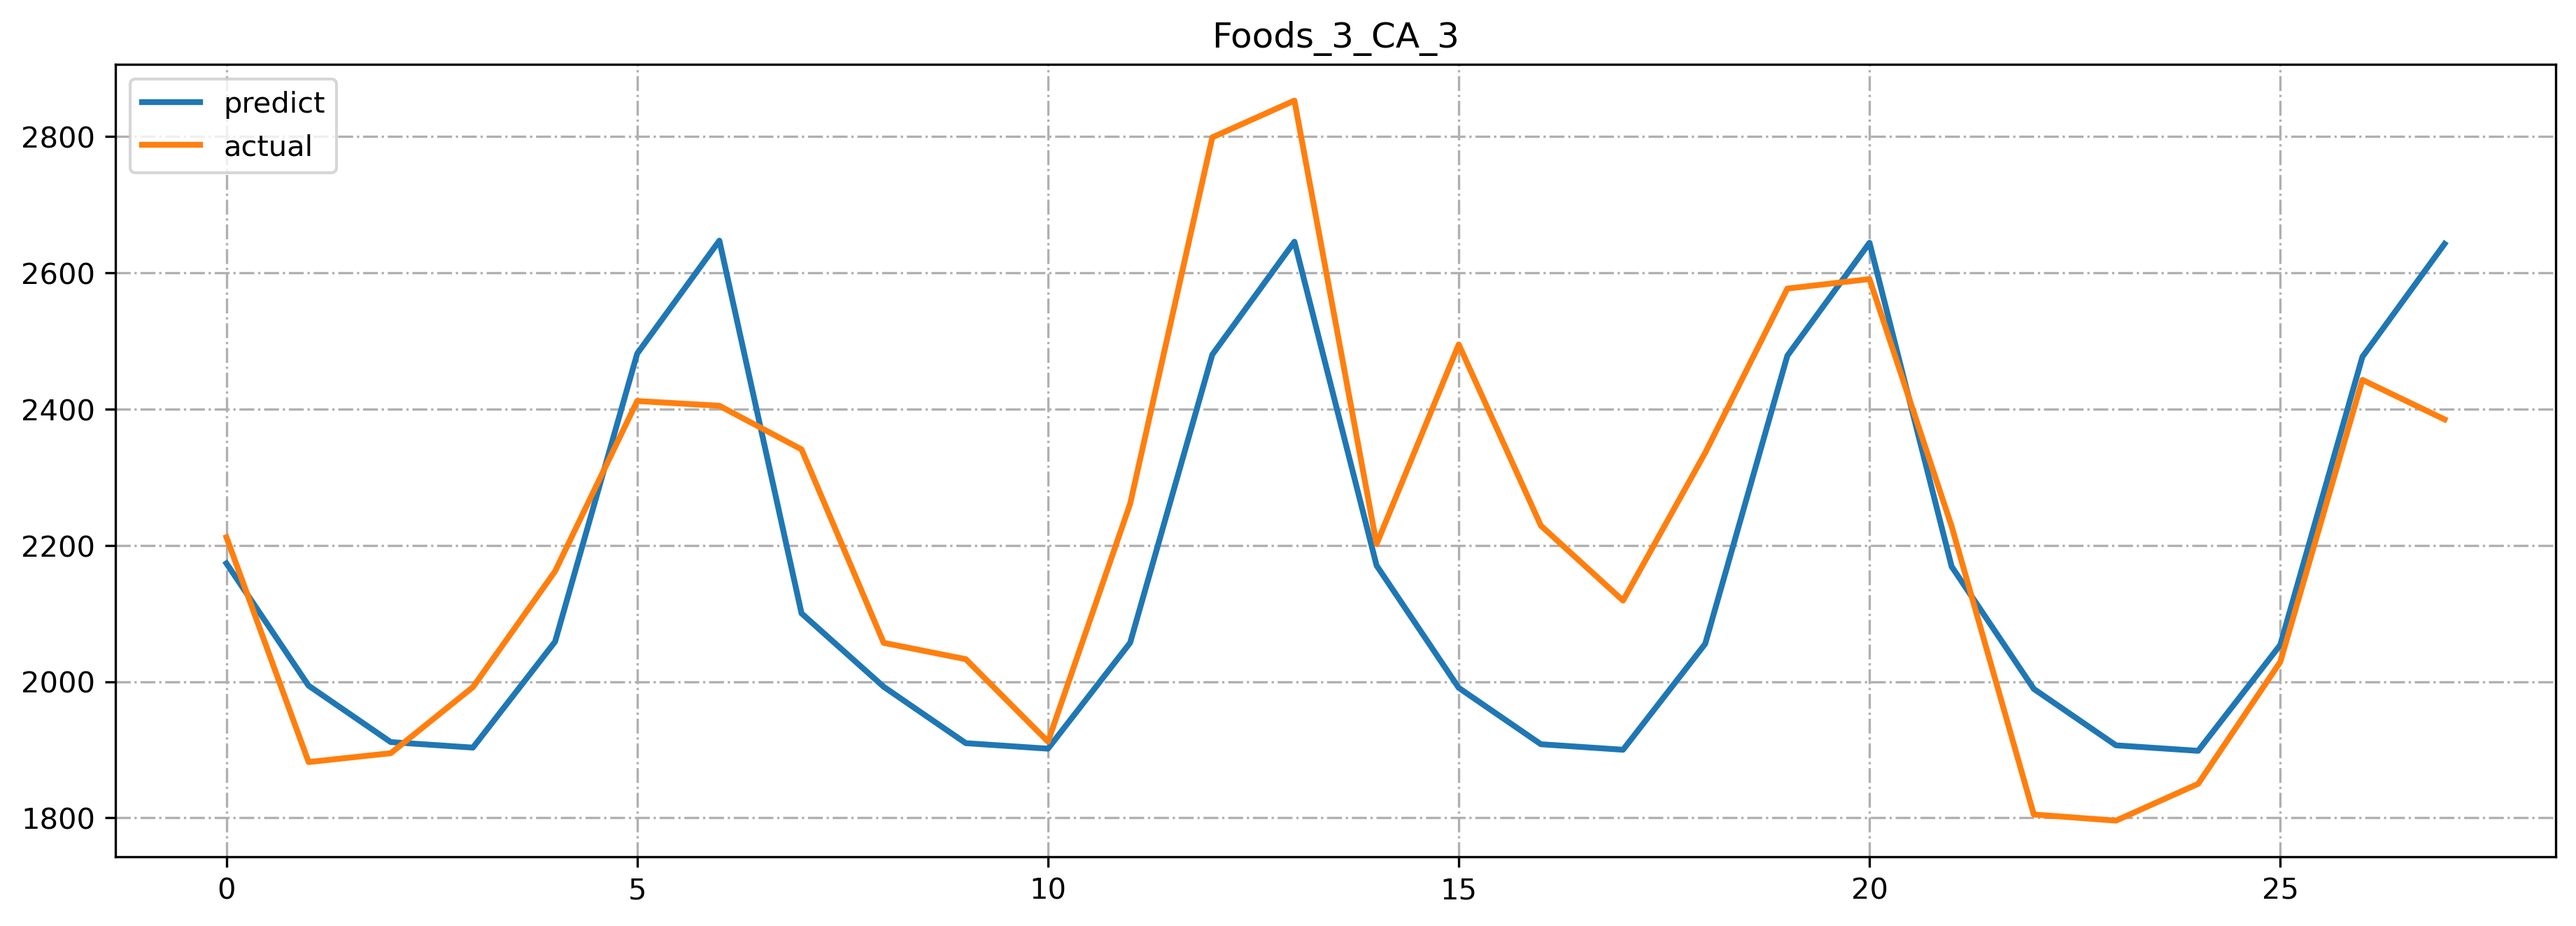

In [137]:
#plot the predict the values and actual values

for i in range(len(y_hat_total.columns)-1):
    predict = y_hat_total.iloc[:,i+1].tail(28).values
    actual = test.iloc[:,i+1].values
    x = [x for x in range(28)]
    fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
    ax.plot(x, predict, linewidth=2.0,label = "predict")
    ax.plot(x, actual, linewidth=2.0,label = "actual")
    ax.legend(loc=2);
    ax.set_title(test.columns[i+1])
    #plt.ylim((0, 450000))
    plt.grid(linestyle='-.')
    plt.show()

In [150]:
#calculate the root mean square error for each variables forecast

from sklearn.metrics import mean_squared_error
from math import sqrt

error_total = []
for i in range(len(y_hat_total.columns)-1):
    predict = y_hat_total.iloc[:,i+1].tail(28).values
    actual = test.iloc[:,i+1].values
    rmse = sqrt(mean_squared_error(actual, predict))
    error_total.append(rmse)

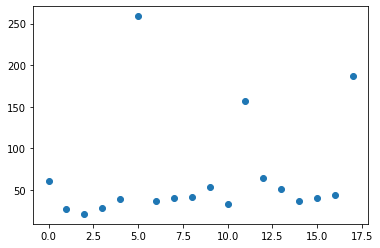

In [154]:
#plot error for each variables
plt.scatter(x = range(len(error_total)), y = error_total)